In [160]:
# IMPORTS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

<h1 style='text-align: center'}>Prediction of the Russian Housing Market</h1>

# 1. Introduction
The Russian housing market, shaped by its diverse regions and economic fluctuations, poses unique challenges for accurate property valuation and investment forecasting. In this project, I will leverage a comprehensive dataset provided by Sberbank, Russia's largest bank, to build sophisticated models that will predict and analyze real estate prices. By incorporating property-specific features and macroeconomic indicators, I will aim to provide a detailed understanding of the key factors that influence property values and market dynamics.


<b>`Main Goal:`</b> The primary objective of this project will be to predict the sale price `(price_doc)` of residential properties in Russia. I will use machine learning techniques to ensure that my model is robust and accurate. However, I will go beyond simple price prediction to explore additional models and targets that will offer a richer and more nuanced analysis of the housing market.

The project will focus on several key components to provide a comprehensive analysis of the Russian housing market:
1. `Price per Square Meter:` I will predict normalized property values to facilitate easier comparisons across regions, enhancing the understanding of relative value.
2. `Price Appreciation/Depreciation:` By estimating the annualized rate of value change, I will provide insights that inform long-term investment strategies and help investors anticipate future property performance.
3. `Time to Sale:` I will develop models to predict the duration a property will remain on the market, assisting in pricing and marketing strategies.
4. `Property Investment Classification:` I will categorize properties by their investment potential, helping investors identify lucrative opportunities quickly.
5. `Sale Likelihood:` I will classify properties based on their probability of selling within specified timeframes, offering real estate professionals a tool to prioritize their marketing efforts.
6. `Market Trend Classification:` I will assess whether local markets are **"Rising", "Stable" or "Falling"** providing strategic insights for homebuyers and investors

# 2. Reading the data
To begin, I’ll load the necessary datasets into my workspace. This step is essential for setting up the core data I’ll need throughout the project.
By reading the data into DataFrames, I’ll be ready to explore its structure and contents, which will help guide the data cleaning and preprocessing steps that follow.

In [2]:
train = pd.read_csv("train.csv/train.csv")
macro = pd.read_csv("macro.csv/macro.csv")

Now, I’ll perform an initial inspection of both the `training` and `macro` datasets to understand their structure, dimensions, and variable types.

In [3]:
train.head()

id   timestamp  full_sq  life_sq  floor  max_floor  material  build_year  \
0   1  2011-08-20       43     27.0    4.0        NaN       NaN         NaN   
1   2  2011-08-23       34     19.0    3.0        NaN       NaN         NaN   
2   3  2011-08-27       43     29.0    2.0        NaN       NaN         NaN   
3   4  2011-09-01       89     50.0    9.0        NaN       NaN         NaN   
4   5  2011-09-05       77     77.0    4.0        NaN       NaN         NaN   

   num_room  kitch_sq  ...  cafe_count_5000_price_2500  \
0       NaN       NaN  ...                           9   
1       NaN       NaN  ...                          15   
2       NaN       NaN  ...                          10   
3       NaN       NaN  ...                          11   
4       NaN       NaN  ...                         319   

  cafe_count_5000_price_4000 cafe_count_5000_price_high  \
0                          4                          0   
1                          3                          0   
2                          3                          0   
3                          2                          1   
4                        108                         17   

   big_church_count_5000  church_count_5000  mosque_count_5000  \
0                     13                 22                  1   
1                     15                 29                  1   
2                     11                 27                  0   
3                      4                  4                  0   
4                    135                236                  2   

   leisure_count_5000  sport_count_5000  market_count_5000  price_doc  
0                   0                52                  4    5850000  
1                  10                66                 14    6000000  
2                   4                67                 10    5700000  
3                   0                26                  3   13100000  
4                  91               195                 14   16331452  

[5 rows x 292 columns]

In [4]:
dimensions = {
    'Training dataset shape': train.shape,
    'Macro dataset shape': macro.shape
}
dimensions

{'Training dataset shape': (30471, 292), 'Macro dataset shape': (2484, 100)}

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30471 entries, 0 to 30470
Columns: 292 entries, id to price_doc
dtypes: float64(119), int64(157), object(16)
memory usage: 67.9+ MB


In [6]:
macro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 100 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   timestamp                                   2484 non-null   object 
 1   oil_urals                                   2484 non-null   float64
 2   gdp_quart                                   2394 non-null   float64
 3   gdp_quart_growth                            2394 non-null   float64
 4   cpi                                         2453 non-null   float64
 5   ppi                                         2453 non-null   float64
 6   gdp_deflator                                2119 non-null   float64
 7   balance_trade                               2453 non-null   float64
 8   balance_trade_growth                        2394 non-null   float64
 9   usdrub                                      2481 non-null   float64
 10  eurrub     

The initial inspection shows that the training dataset is large, with 30,471 rows and 292 columns, while the macro dataset is smaller, with 2,484 rows and 100 columns. Both datasets are predominantly numerical, with some categorical columns that may require encoding.

# 3. Data formatting
 I’ll prepare and structure the datasets for seamless integration and analysis. First, I’ll ensure that date information in both datasets is standardized by converting the `timestamp` column to a datetime format. After this,<b> I’ll merge the training and macr datasets</b>  on the `timestamp` column, allowing me to enrich the training data with additional macroeconomic features. This data formatting step is crucial for aligning and consolidating the information, setting up a consistent foundation for the modeling phase.

In [7]:
train['timestamp'] = pd.to_datetime(train['timestamp'])
macro['timestamp'] = pd.to_datetime(macro['timestamp'])

In [8]:
train['timestamp']

0       2011-08-20
1       2011-08-23
2       2011-08-27
3       2011-09-01
4       2011-09-05
           ...    
30466   2015-06-30
30467   2015-06-30
30468   2015-06-30
30469   2015-06-30
30470   2015-06-30
Name: timestamp, Length: 30471, dtype: datetime64[ns]

In [9]:
merged_df = pd.merge(train, macro, on="timestamp", how="left")

In [10]:
merged_df.shape

(30471, 391)

After merging, I checked the shape of the DataFrame to confirm success. The result is `(30471, 391)`, matching the original 30,471 rows and showing an increase in columns from 292 to 391. This confirms that the merge was successful, with the macro features correctly added by `timestamp`.

# 4. Missing values


In this step, I’ll analyze and handle missing values in the merged dataset to improve data quality for analysis and modeling. Missing values can impact the performance of machine learning models, so it's essential to assess the extent of missing data and make informed decisions about handling it. First, I’ll start by identifying which columns contain missing values and visualize the proportion of missing data in each of these columns.

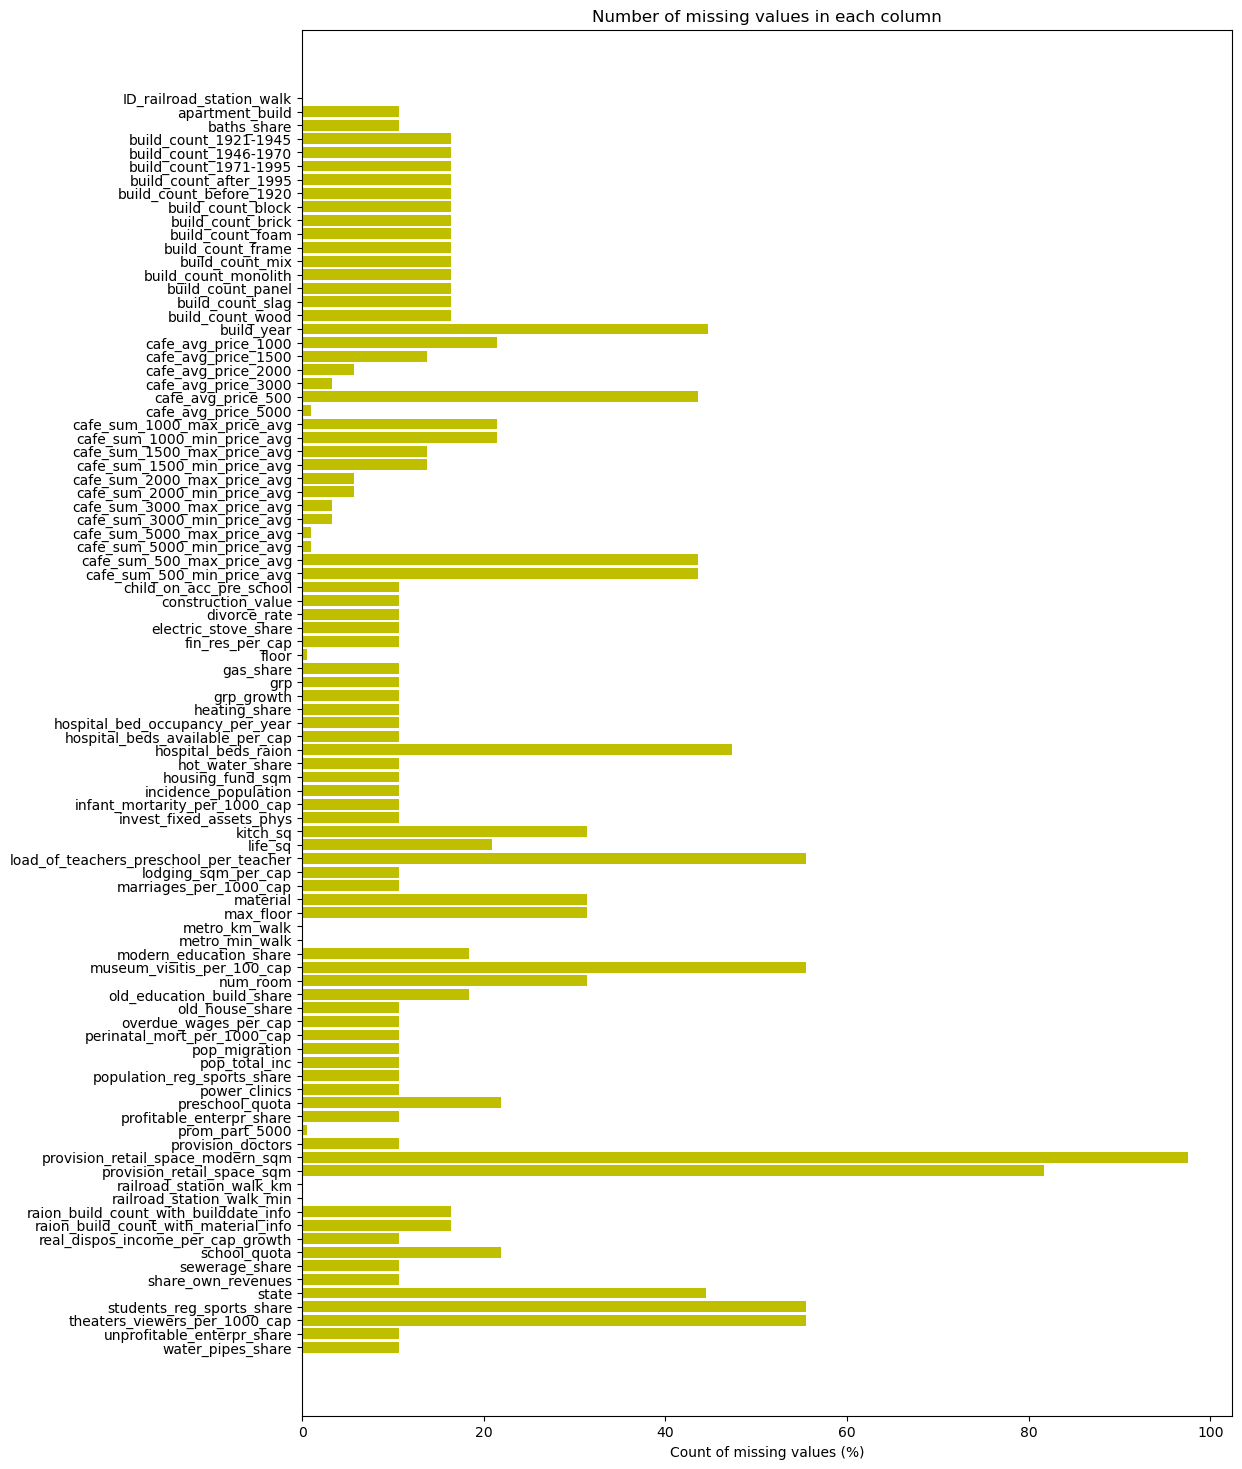

In [11]:
missing_df = merged_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df[missing_df['missing_count'] > 0]
missing_df = missing_df.sort_values(by='column_name', ascending=False)

ind = np.arange(missing_df.shape[0])
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values / merged_df.shape[0] * 100, color='y')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values (%)")
ax.set_title("Number of missing values in each column")
plt.show()

In [12]:
print(f"Number of columns with missing values: {len(missing_df)}")

Number of columns with missing values: 93


Next, I’ll set a threshold to decide which columns to keep based on the percentage of missing values. I’ve chosen a threshold of 50%, meaning that any column with more than 50% missing values will be removed. This helps to eliminate columns that are too incomplete to provide meaningful information, ensuring that the dataset remains relevant and manageable for further analysis.

In [13]:
threshold = merged_df.shape[0] * 0.5
threshold

15235.5

In [14]:
merged_df = merged_df.loc[:, merged_df.isnull().sum(axis=0) <= threshold]

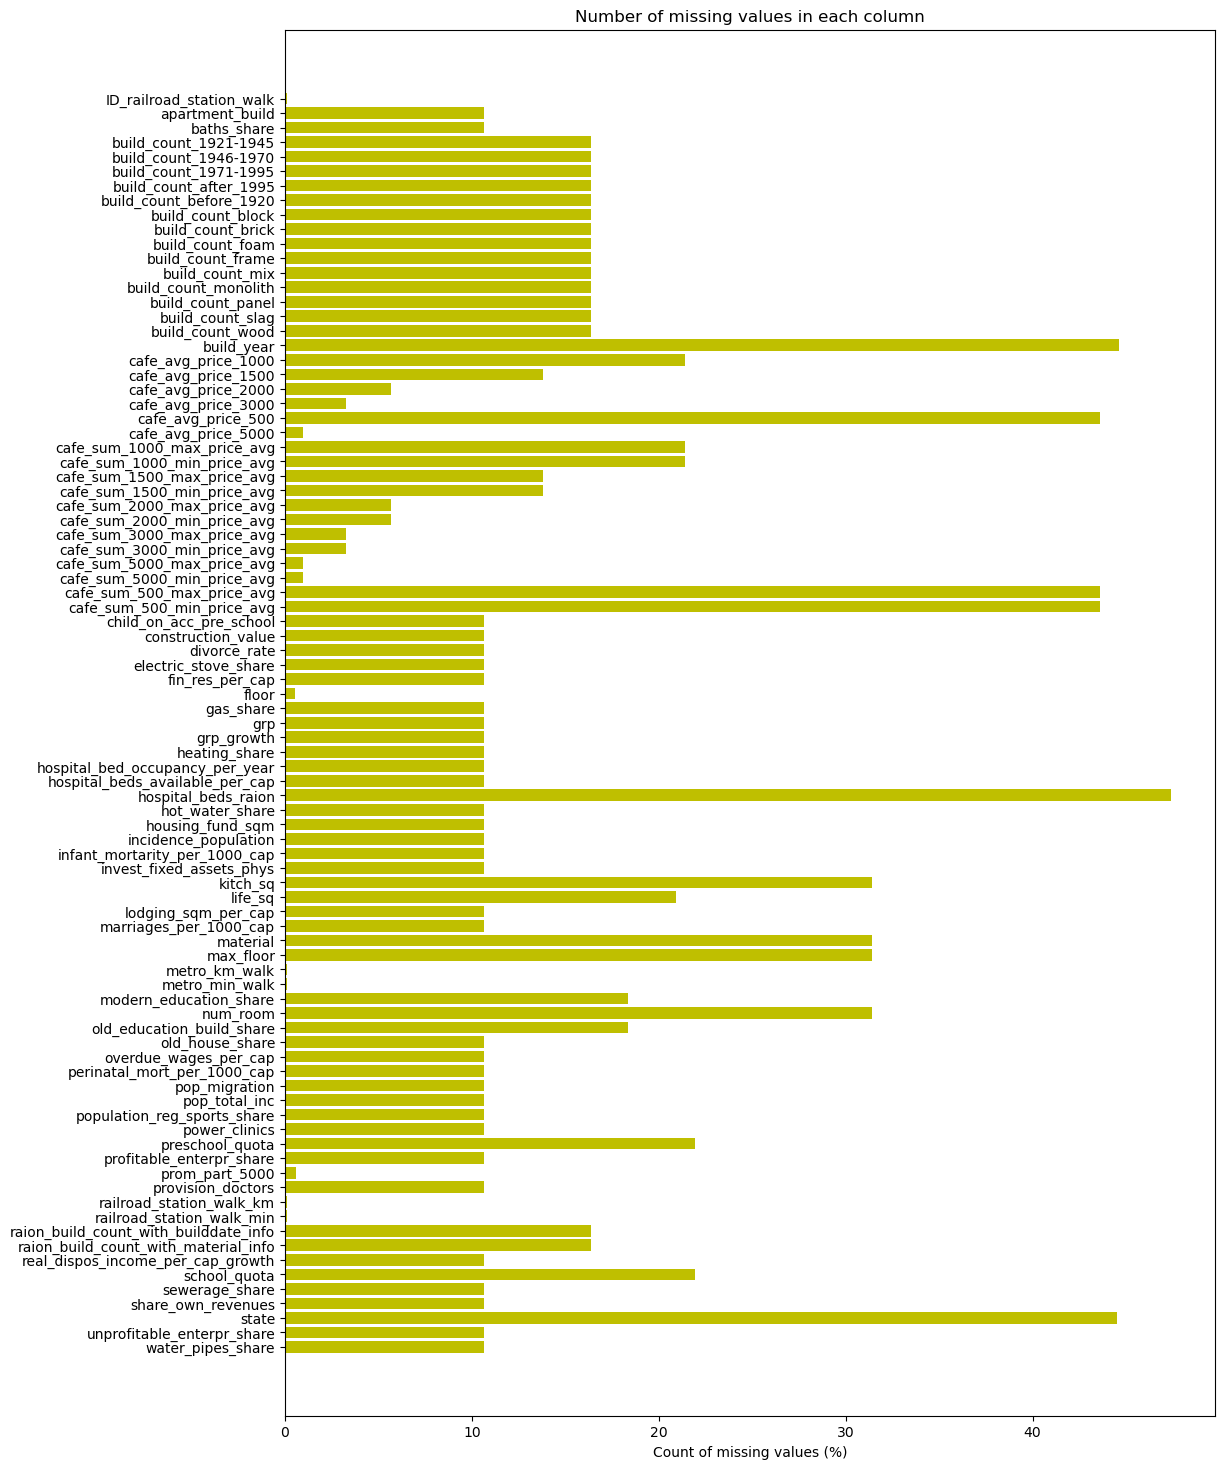

In [15]:
missing_df = merged_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df[missing_df['missing_count'] > 0]
missing_df = missing_df.sort_values(by='column_name', ascending=False)

ind = np.arange(missing_df.shape[0])
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values / merged_df.shape[0] * 100, color='y')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values (%)")
ax.set_title("Number of missing values in each column")
plt.show()

In [16]:
print(f"Number of columns with missing values: {len(missing_df)}")

Number of columns with missing values: 87


6 columns are dropped from the dataset.

Now, I’ll address the missing values in the dataset by filling them with appropriate values based on the type of data in each column.

In [17]:
columns_to_fill_with_zero = [
    'ID_railroad_station_walk',
    'apartment_build',
    'baths_share',
    'build_count_1921-1945',
    'build_count_1946-1970',
    'build_count_1971-1995',
    'build_count_after_1995',
    'build_count_before_1920',
    'build_count_block',
    'build_count_brick',
    'build_count_foam',
    'build_count_frame',
    'build_count_mix',
    'build_count_slag',
    'build_count_monolith',
    'build_count_panel',
    'build_count_wood',
    'cafe_avg_price_1000',
    'cafe_avg_price_1500',
    'cafe_avg_price_2000',
    'cafe_avg_price_3000',
    'cafe_avg_price_500',
    'cafe_avg_price_5000',
    'construction_value',
    'electric_stove_share',
    'gas_share',
    'heating_share',
    'sewerage_share', 
    'water_pipes_share', 
    'modern_education_share', 
    'school_quota',
    'preschool_quota',
    'hospital_bed_occupancy_per_year',
    'hospital_beds_available_per_cap',
    'hospital_beds_raion',
    'provision_doctors', 
    'railroad_station_walk_km',
    'railroad_station_walk_min', 
    'raion_build_count_with_builddate_info',
    'raion_build_count_with_material_info',
    'hot_water_share',
    'housing_fund_sqm',
    'cafe_sum_1000_max_price_avg',
    'cafe_sum_1000_min_price_avg',
    'cafe_sum_1500_max_price_avg',
    'cafe_sum_1500_min_price_avg',
    'cafe_sum_2000_max_price_avg',
    'cafe_sum_2000_min_price_avg',
    'cafe_sum_3000_max_price_avg',
    'cafe_sum_3000_min_price_avg',
    'cafe_sum_5000_max_price_avg',
    'cafe_sum_5000_min_price_avg',
    'cafe_sum_500_max_price_avg',
    'cafe_sum_500_min_price_avg',
    'profitable_enterpr_share', 
    'unprofitable_enterpr_share', 
    'share_own_revenues',
    'metro_km_walk',
    'metro_min_walk'
]

merged_df.loc[:, columns_to_fill_with_zero] = merged_df.loc[:, columns_to_fill_with_zero].fillna(0)

I have a problem with two of the columns that I want to fill with median values: `child_on_acc_pre_school` and `old_education_build_share`. These columns contain irregular numeric formats, such as commas instead of decimal points, and some non-numeric characters. 

To address this, I’ll first standardize the formatting by replacing commas with decimal points. Next, I’ll convert the columns to numeric, setting any entries that can't be converted (e.g., symbols or text) to `NaN`. Once the data is clean and in a numeric format, I’ll fill the missing values, including the `NaN` entries, with each column's median. 

This approach will ensure that these columns are consistent, usable for further analysis, and appropriately filled where data was missing or invalid.

In [18]:
merged_df.child_on_acc_pre_school.unique()

array(['#!', '7,311', '3,013', '16,765', nan], dtype=object)

In [19]:
merged_df.old_education_build_share.unique()

array([nan, '23,14', '25,47', '8,2517'], dtype=object)

In [20]:
columns_to_clean = ['child_on_acc_pre_school', 'old_education_build_share']

for col in columns_to_clean:
    merged_df[col] = merged_df[col].replace({',': '.'}, regex=True) 
    merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')  

In [21]:
merged_df.child_on_acc_pre_school.unique()

array([   nan,  7.311,  3.013, 16.765])

In [22]:
merged_df.old_education_build_share.unique()

array([    nan, 23.14  , 25.47  ,  8.2517])

I can fill them already!

In [23]:
columns_to_fill_with_median = [
    'fin_res_per_cap', 
    'grp_growth', 
    'invest_fixed_assets_phys',
    'overdue_wages_per_cap', 
    'real_dispos_income_per_cap_growth',
    'floor', 
    'max_floor', 
    'num_room', 
    'housing_fund_sqm',
    'kitch_sq', 
    'lodging_sqm_per_cap', 
    'old_education_build_share', 
    'old_house_share',
    'incidence_population', 
    'infant_mortarity_per_1000_cap',
    'perinatal_mort_per_1000_cap', 
    'marriages_per_1000_cap',
    'pop_total_inc', 
    'population_reg_sports_share',
    'divorce_rate',
    'grp',
    'power_clinics',
    'life_sq',
    'pop_migration',
    'prom_part_5000',
    'build_year',
    'child_on_acc_pre_school'
]

merged_df[columns_to_fill_with_median] = merged_df[columns_to_fill_with_median].fillna(merged_df[columns_to_fill_with_median].median())

In [24]:
columns_to_fill_with_mode = [
    'material',
    'state'
]

for column in columns_to_fill_with_mode:
    mode_value = merged_df[column].mode()[0]  
    merged_df[column] = merged_df[column].fillna(mode_value) 

In [25]:
missing_df = merged_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df[missing_df['missing_count'] > 0]

if len(missing_df) == 0:
    print("No columns with missing values.")

No columns with missing values.


# 5. Reducing Redundancy and Simplifying Feature Space

Correlations if 2 features are highly correlated, remove one of them, if there are too many left, do a PCA with 2, 3, 4, 5 components, and see which features have high impact in the pca components, and remove these with high values.

In this step, I will analyze correlations among the features to reduce redundancy and improve model efficiency by removing highly correlated features. Here's the plan:

1. Identify and Remove Highly Correlated Features: First, I’ll calculate correlation values among the numeric features. If any pairs of features have a high correlation (e.g., above a certain threshold), I'll remove one of the two to avoid redundant information in the dataset.
2. Principal Component Analysis (PCA): If there are still many features remaining, I’ll perform PCA to reduce dimensionality further. I'll try different numbers of components (e.g., 2, 3, 4, and 5) to see how much variance each set can capture. By examining the impact of individual features on the principal components, I can identify which features contribute most strongly and consider removing those with high influence in the components.

To begin, I’ll separate the dataset into numeric columns, which can be analyzed for correlations, and object or date columns, which will be excluded from this specific analysis.

However, first and foremost, I'll separate the `target variable (price_doc in my case)` from the rest of the dataset. The target variable should be excluded from the correlation analysis to avoid the risk of accidentally dropping it if it appears in a pair with another highly correlated feature. By isolating the target, I can safely analyze and handle correlations within the predictor features only, ensuring the target remains intact for our final predictive model.

In [26]:
target = merged_df['price_doc']

numeric_columns_df = merged_df.select_dtypes(include=['float64', 'int64']).drop(columns=['price_doc'])
object_dt_columns = merged_df.select_dtypes(include = ['object', 'datetime64[ns]'])

This setup enables me to focus on numeric features for correlation analysis and PCA, streamlining the process of feature selection and dimensionality reduction.

In [27]:
correlation_matrix = numeric_columns_df.corr()

In [28]:
correlation_matrix

id   full_sq   life_sq     floor  \
id                                   1.000000  0.021447  0.011919 -0.021096   
full_sq                              0.021447  1.000000  0.151406  0.089085   
life_sq                              0.011919  0.151406  1.000000  0.032337   
floor                               -0.021096  0.089085  0.032337  1.000000   
max_floor                            0.041155  0.057650  0.033413  0.371492   
...                                       ...       ...       ...       ...   
seats_theather_rfmin_per_100000_cap  0.410311  0.020688 -0.004981 -0.029345   
bandwidth_sports                     0.940352  0.023268  0.008694 -0.022411   
population_reg_sports_share          0.828300  0.012166  0.010660 -0.012807   
apartment_build                     -0.413598 -0.024058 -0.007522  0.011149   
apartment_fund_sqm                   0.217225  0.021801 -0.004971 -0.017556   

                                     max_floor  material  build_year  \
id                                    0.041155  0.244193   -0.003688   
full_sq                               0.057650  0.017168   -0.002632   
life_sq                               0.033413  0.014049   -0.002229   
floor                                 0.371492 -0.019545    0.000363   
max_floor                             1.000000  0.057608   -0.000203   
...                                        ...       ...         ...   
seats_theather_rfmin_per_100000_cap   0.010843  0.044859   -0.008081   
bandwidth_sports                      0.038524  0.231938   -0.004213   
population_reg_sports_share           0.037430  0.239475   -0.000693   
apartment_build                      -0.013110 -0.048282    0.002649   
apartment_fund_sqm                    0.001980 -0.011621   -0.007434   

                                     num_room  kitch_sq     state  ...  \
id                                  -0.039330  0.000415 -0.009777  ...   
full_sq                              0.333761  0.009695 -0.039139  ...   
life_sq                              0.170746  0.003408 -0.048718  ...   
floor                               -0.002176 -0.007286 -0.088592  ...   
max_floor                           -0.016924  0.020689 -0.057017  ...   
...                                       ...       ...       ...  ...   
seats_theather_rfmin_per_100000_cap  0.012791 -0.005459 -0.068029  ...   
bandwidth_sports                    -0.031955  0.000226 -0.006874  ...   
population_reg_sports_share         -0.046353  0.002415  0.035345  ...   
apartment_build                     -0.023399 -0.002633  0.076875  ...   
apartment_fund_sqm                   0.023596 -0.005488 -0.074570  ...   

                                     load_on_doctors  power_clinics  \
id                                         -0.762572      -0.800264   
full_sq                                    -0.023697      -0.021646   
life_sq                                     0.000281      -0.009083   
floor                                       0.033539       0.005701   
max_floor                                  -0.027545      -0.033569   
...                                              ...            ...   
seats_theather_rfmin_per_100000_cap        -0.875973      -0.146015   
bandwidth_sports                           -0.822460      -0.834571   
population_reg_sports_share                -0.442357      -0.853927   
apartment_build                             0.666491       0.038768   
apartment_fund_sqm                         -0.731925      -0.048033   

                                     hospital_beds_available_per_cap  \
id                                                         -0.679912   
full_sq                                                    -0.029871   
life_sq                                                    -0.012123   
floor                                                       0.009160   
max_floor                                                  -0.025232   
...                                                    

In [29]:
threshold = 0.8
highly_correlated_pairs = set()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            highly_correlated_pairs.add(colname)

reduced_df = numeric_columns_df.drop(columns=highly_correlated_pairs)

In [30]:
numeric_columns_df.shape

(30471, 367)

In [31]:
reduced_df.shape

(30471, 115)

In [32]:
reduced_df = pd.concat([reduced_df, object_dt_columns, target], axis=1)

In [33]:
reduced_df.shape

(30471, 133)

In [34]:
reduced_df.to_csv('reduced_data.csv', index=False)

After performing correlation analysis, I identified and removed highly correlated features, which significantly reduced the dimensionality of the dataset. Initially, I had `367 numeric columns` (without the target variable), but after applying the correlation threshold, `I am left with 115 columns`. This reduction helps mitigate issues like multicollinearity and makes the dataset more manageable for further processing, including modeling.

After reducing redundancy among numeric features, I reintroduced the target variable `(price_doc)` along with object and datetime columns, which were temporarily excluded during the correlation analysis. By adding these back, I now have a complete dataset that includes `133 columns` (`from 385` in the beginning) — covering numeric features, categorical/date features, and the target variable. This comprehensive dataset provides a well-rounded foundation for EDA, ensuring that I capture the full range of information across different data types and can better understand patterns, relationships, and distributions in preparation for model building.

# 6. Exploratory Data Analysis (EDA)

## Target variable EDA

In this step, I’ll start by exploring the target variable, `price_doc`, to understand its distribution, check for any skewness or outliers, and decide if any transformations are needed. After that, I’ll look at the rest of the dataset to identify patterns, relationships between features, and any potential data issues. This will give me a clearer understanding of the data before moving on to modeling.

Let's visualize the distribution of the target variable using a histogram combined with a `Kernel Density Estimate (KDE)`. This will allow me to see how the prices are distributed—whether they are skewed, follow a normal distribution, or have any other noticeable patterns. Understanding the distribution of the target variable is an important step in preparing the data for further modeling.

count    3.047100e+04
mean     7.123035e+06
std      4.780111e+06
min      1.000000e+05
25%      4.740002e+06
50%      6.274411e+06
75%      8.300000e+06
max      1.111111e+08
Name: price_doc, dtype: float64


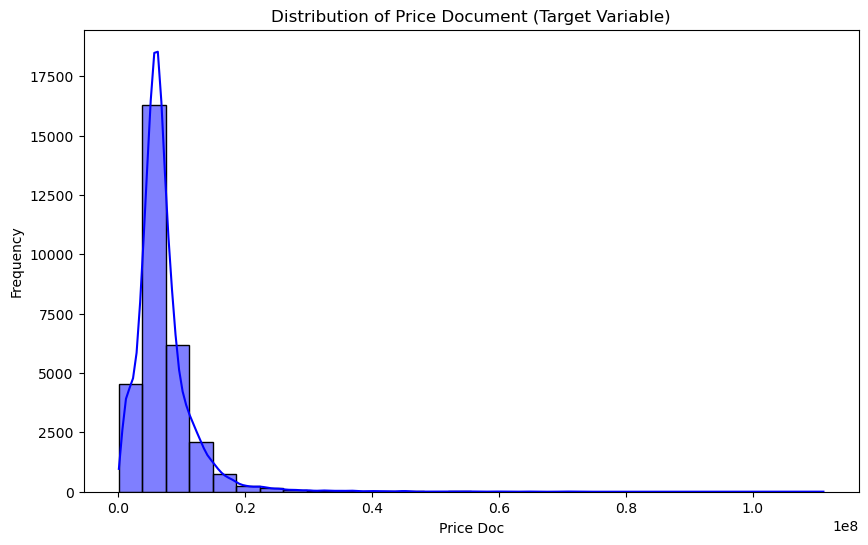

In [35]:
print(reduced_df['price_doc'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(reduced_df['price_doc'], kde=True, color='blue', bins=30)
plt.title("Distribution of Price Document (Target Variable)")
plt.xlabel("Price Doc")
plt.ylabel("Frequency")
plt.show()

Based on the histogram, several key insights can be drawn about its distribution.

**1. Right-Skewed Distribution:** <br>
The distribution of price_doc is highly skewed to the right, which means it exhibits positive skewness. Most of the data points (housing prices) are clustered towards the lower end of the price range. This indicates that the majority of properties are relatively inexpensive. However, there are a few much higher-priced properties that form a long tail on the right side of the distribution. This suggests that while most houses are priced similarly within a lower range, there are a few outliers in the form of very expensive properties.

**2. Presence of Outliers:** <br>
The histogram reveals the presence of extreme values that are far from the main cluster of data points. These outliers, which represent very high-priced properties, are important to identify as they can have a significant impact on the analysis. Extreme values may distort the model's ability to generalize and could lead to overfitting if not properly managed.

**3. Potential for Log Transformation:** <br>
Given the strong right skewness in the distribution, applying a log transformation to the price_doc variable may help to normalize the data. A log transformation is commonly used to reduce the effect of outliers and make the distribution more symmetrical. This could potentially improve the performance of certain machine learning models by reducing the impact of extreme values and helping models learn better from the data. A more normally distributed target variable can often lead to more accurate predictions.

In [36]:
reduced_df['log_price_doc'] = np.log(reduced_df['price_doc'] + 1)

In [37]:
reduced_df['log_price_doc'].describe()

count    30471.000000
mean        15.609483
std          0.604574
min         11.512935
25%         15.371548
50%         15.651990
75%         15.931766
max         18.526041
Name: log_price_doc, dtype: float64

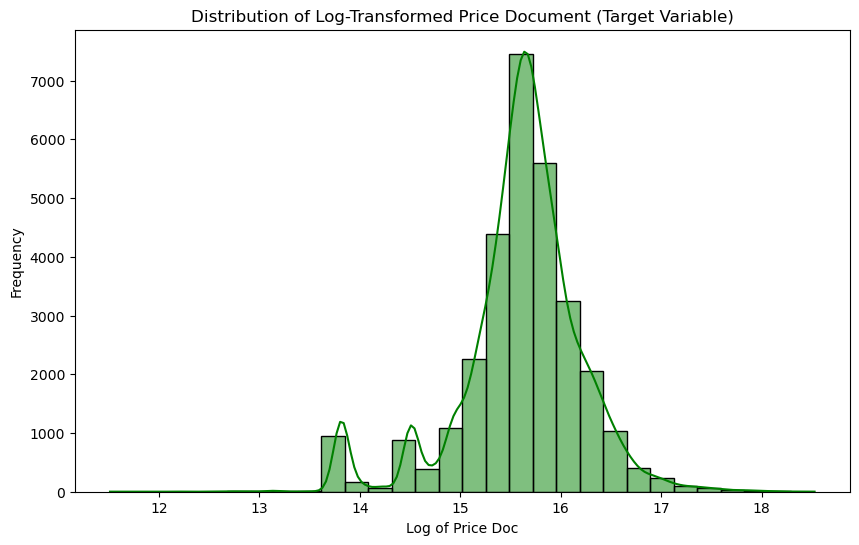

In [38]:
plt.figure(figsize=(10, 6))
sns.histplot(reduced_df['log_price_doc'], kde=True, color='green', bins=30)
plt.title("Distribution of Log-Transformed Price Document (Target Variable)")
plt.xlabel("Log of Price Doc")
plt.ylabel("Frequency")
plt.show()

After the log transformation, the distribution of `price_doc` has become more symmetric and less skewed, with a more bell-shaped curve. The concentration of housing prices is now more clearly defined around the range of 15 to 16, whereas the original distribution had a heavier concentration in lower price ranges. While the right tail has been reduced, there is still a slight tail, indicating the presence of some high-priced properties. Overall, the transformation has improved the distribution, making it more suitable for modeling, but the remaining tail suggests that extreme values still need attention.

Trimming Outliers using IQR:

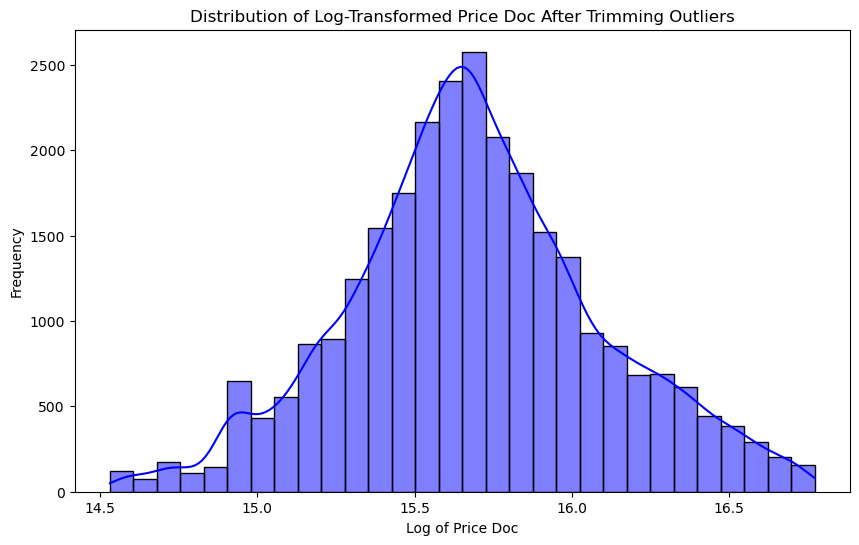

In [39]:
Q1 = reduced_df['log_price_doc'].quantile(0.25)
Q3 = reduced_df['log_price_doc'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

reduced_df = reduced_df[(reduced_df['log_price_doc'] >= lower_bound) & (reduced_df['log_price_doc'] <= upper_bound)]

plt.figure(figsize=(10, 6))
sns.histplot(reduced_df['log_price_doc'], kde=True, color='blue', bins=30)
plt.title("Distribution of Log-Transformed Price Doc After Trimming Outliers")
plt.xlabel("Log of Price Doc")
plt.ylabel("Frequency")
plt.show()

## Other аnalysis

After completing the EDA for the target variable, I will now focus on identifying the features most strongly correlated with the **log-transformed** `price_doc` and conduct EDA on these key features.

In [40]:
reduced_df_dummies = pd.get_dummies(reduced_df)

top_20_features = reduced_df_dummies.corr()['log_price_doc'].nlargest(21)

top_20_df = reduced_df_dummies[top_20_features.index]

In [41]:
top_20_features

log_price_doc                           1.000000
price_doc                               0.962305
num_room                                0.434484
raion_popul                             0.319367
cafe_sum_1000_min_price_avg             0.297781
market_count_5000                       0.291450
product_type_Investment                 0.284008
sport_objects_raion                     0.279395
cafe_sum_1500_min_price_avg             0.277543
healthcare_centers_raion                0.264539
full_sq                                 0.255696
market_count_3000                       0.248424
cafe_sum_500_min_price_avg              0.231467
sport_count_1000                        0.229628
prom_part_5000                          0.222058
shopping_centers_raion                  0.210677
raion_build_count_with_material_info    0.209187
cafe_sum_2000_min_price_avg             0.209099
build_count_1946-1970                   0.199769
build_count_block                       0.196782
build_count_monolith

In [42]:
top_20_df.columns

Index(['log_price_doc', 'price_doc', 'num_room', 'raion_popul',
       'cafe_sum_1000_min_price_avg', 'market_count_5000',
       'product_type_Investment', 'sport_objects_raion',
       'cafe_sum_1500_min_price_avg', 'healthcare_centers_raion', 'full_sq',
       'market_count_3000', 'cafe_sum_500_min_price_avg', 'sport_count_1000',
       'prom_part_5000', 'shopping_centers_raion',
       'raion_build_count_with_material_info', 'cafe_sum_2000_min_price_avg',
       'build_count_1946-1970', 'build_count_block', 'build_count_monolith'],
      dtype='object')

I will start with histograms and scatterplots. This will allow me to visually assess the distribution patterns, skewness, and potential outliers for each feature. By understanding these characteristics, I can identify the need for any transformations or adjustments for extreme values. This initial analysis will provide a foundation for deeper exploration of how these features relate to the target variable.

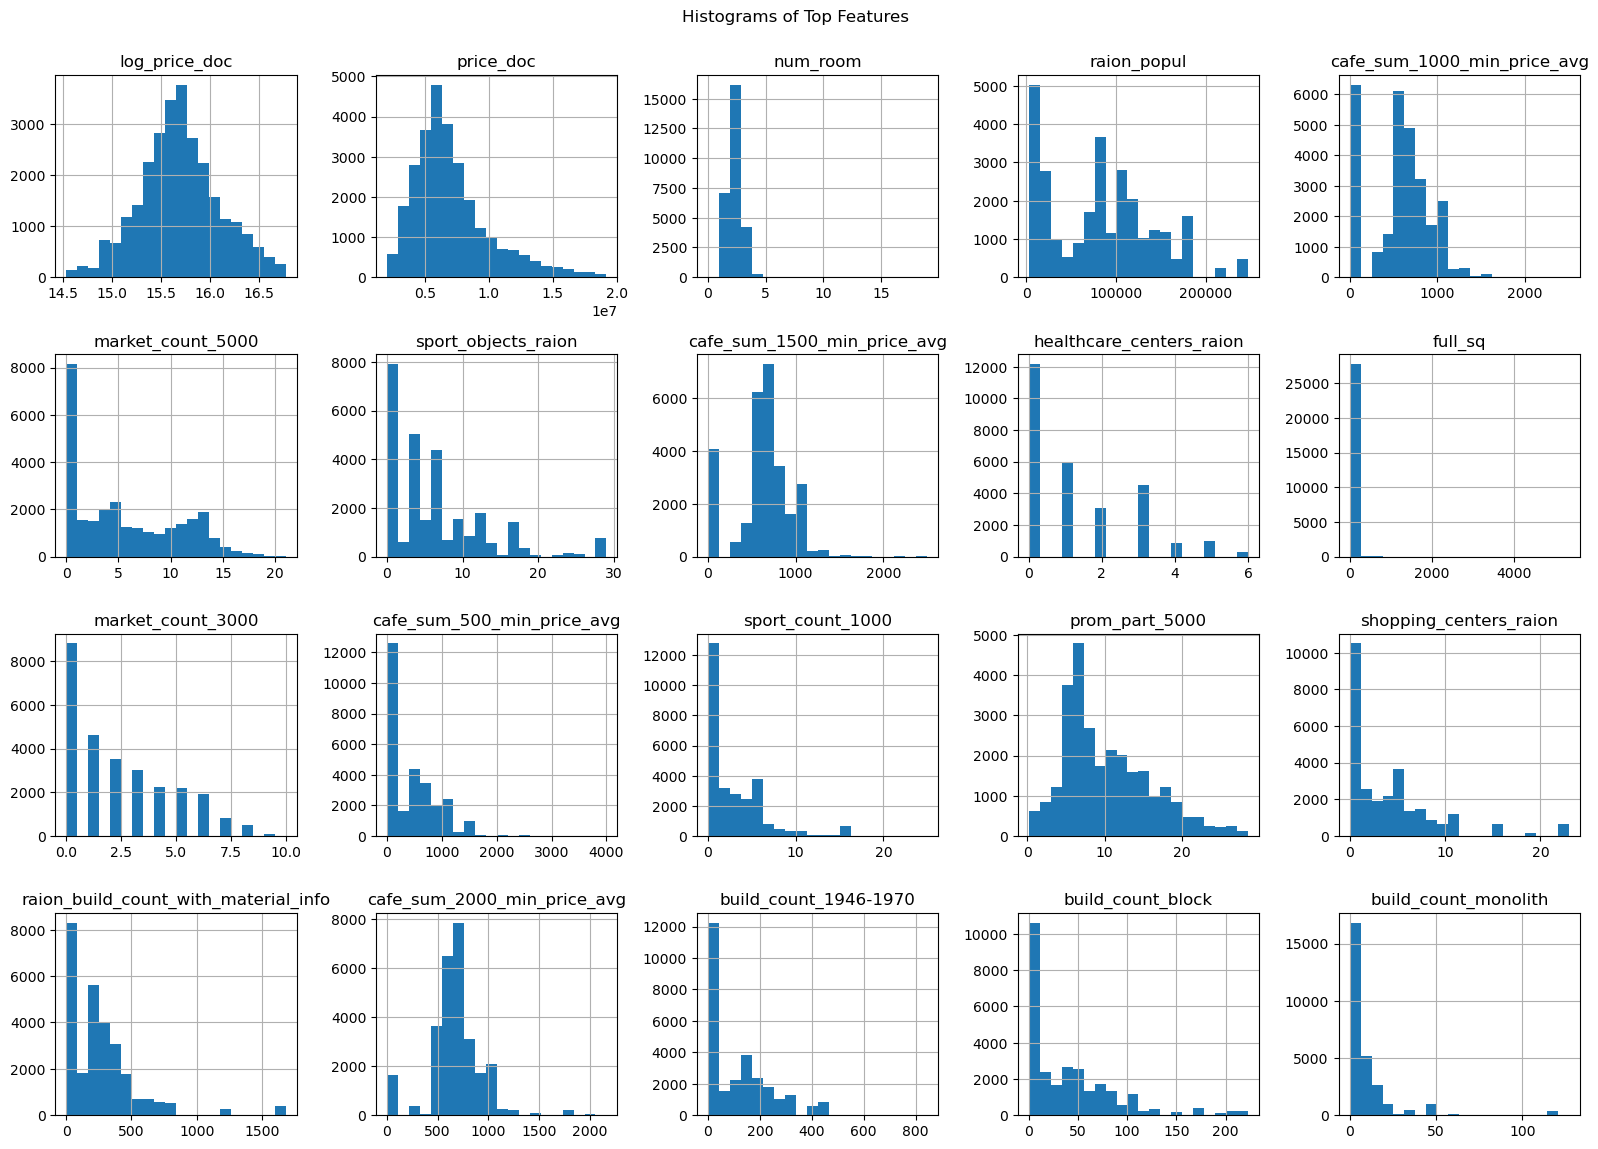

In [43]:
top_20_df.hist(bins=20, figsize=(16, 14), layout=(5, 5))
plt.suptitle('Histograms of Top Features', y=1)
plt.tight_layout()
plt.show()

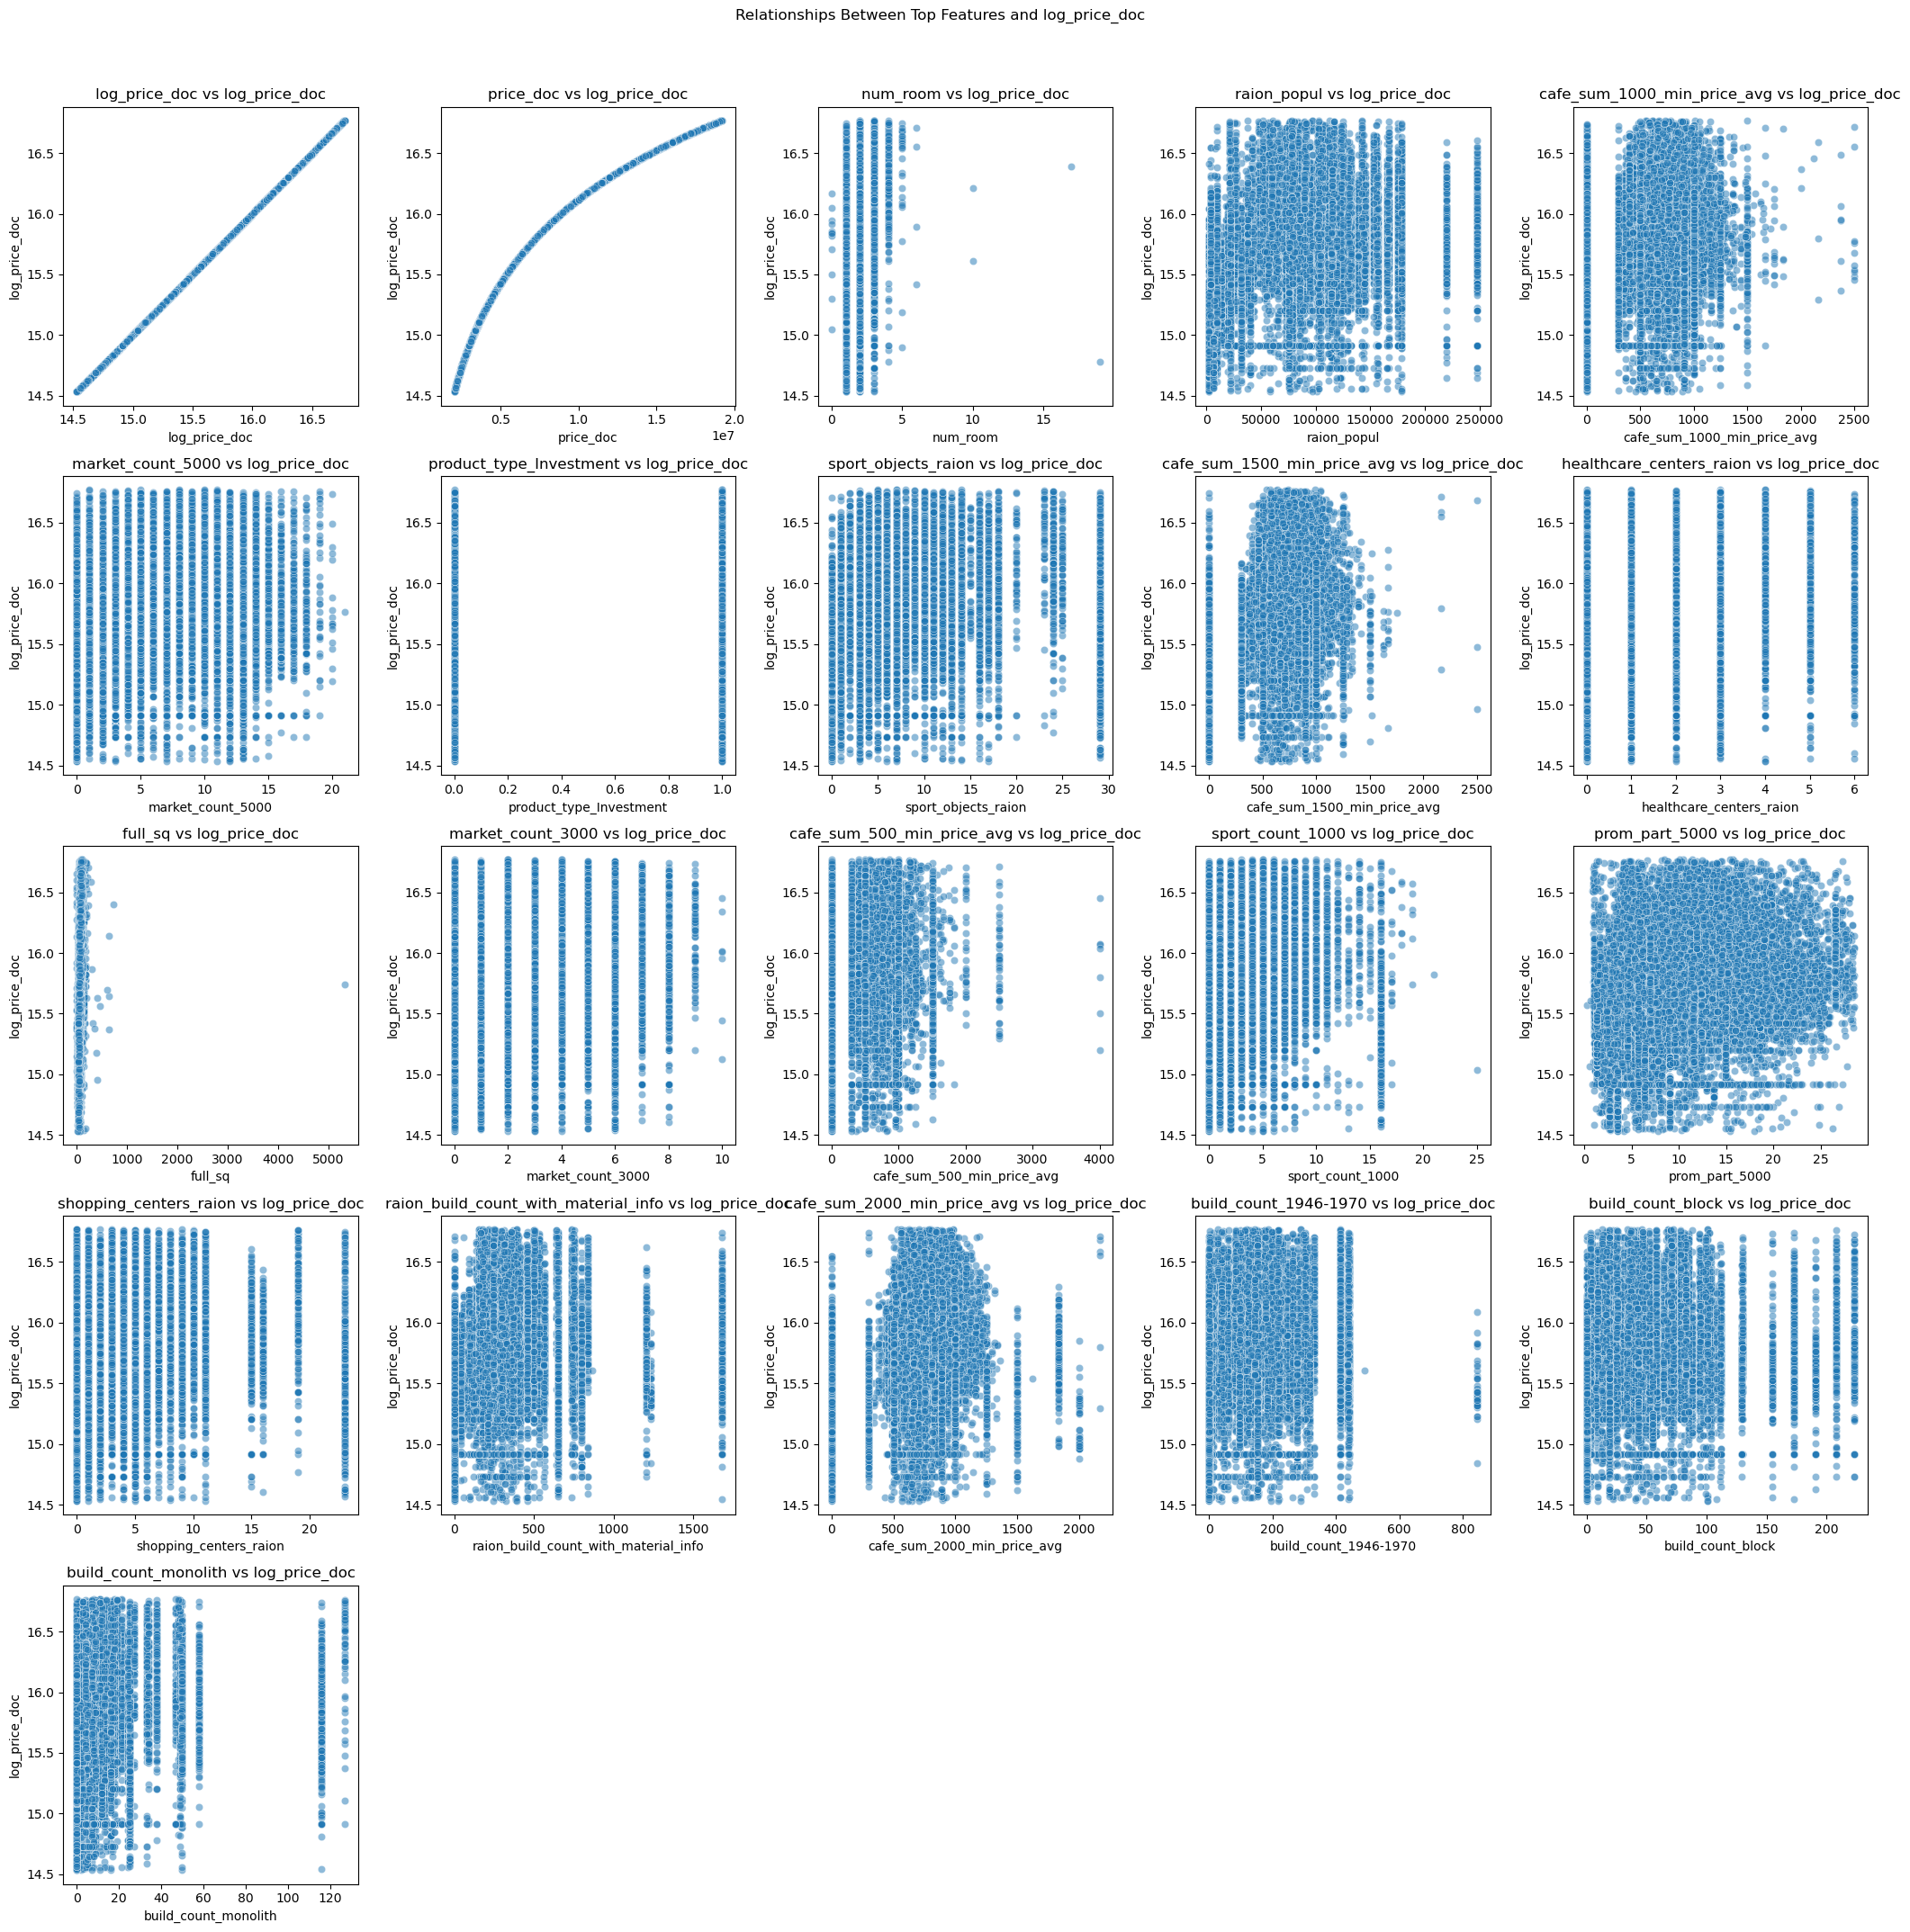

In [44]:
plt.figure(figsize=(21, 21))

for i, feature in enumerate(top_20_df.columns):
    plt.subplot(5, 5, i + 1)
    sns.scatterplot(data=top_20_df, x=feature, y='log_price_doc', alpha=0.5)
    plt.title(f'{feature} vs log_price_doc')
    
plt.suptitle('Relationships Between Top Features and log_price_doc', y=1.02)
plt.tight_layout()
plt.show()

Let's start examine the columns one by one.
1. **Analysis of `log_price_doc` column**: <br>
The distribution of the column is nearly normal, which is expected since it’s derived from the logarithm of `price_doc`. This is a positive indicator, as a normal distribution is ideal for many statistical analyses. With no significant skewness or outliers, no further transformation is needed.
2. **Analysis of `num_room`(number of living rooms) column**: <br>
The histogram shows an asymmetric distribution with a peak at lower values and a long right tail, indicating that most properties have a small number of rooms, while a few have many. This suggests that small homes dominate the dataset, with some larger, potentially luxury properties. <br>
To begin the in-depth analysis of the **`num_room`** feature, I will first calculate its skewness to assess the distribution and determine if any transformations or adjustments are necessary.

In [45]:
print(f"Skewness of num_room: {skew(reduced_df['num_room'])}")

Skewness of num_room: 1.3911139219831004


Expected positively skewed distribution. It may be beneficial to apply transformations or categorize the feature to improve its distribution for modeling.

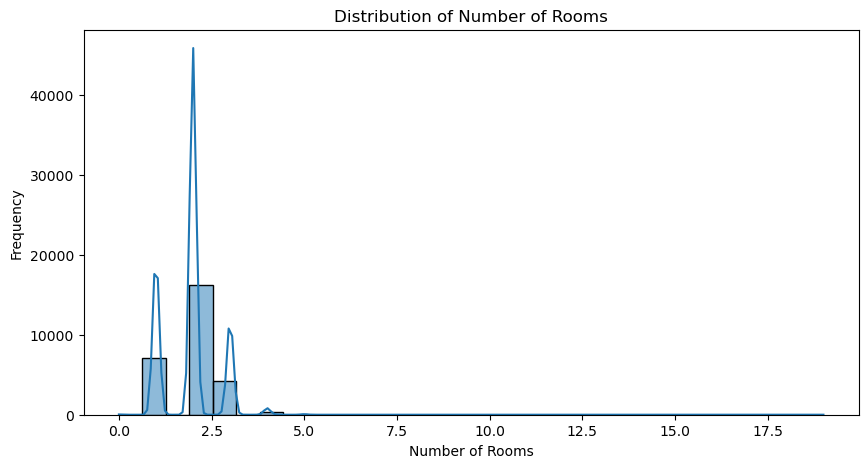

In [46]:
plt.figure(figsize=(10, 5))
sns.histplot(reduced_df['num_room'], kde=True, bins=30)
plt.title('Distribution of Number of Rooms')
plt.xlabel('Number of Rooms')
plt.ylabel('Frequency')
plt.show()

In [47]:
corr_with_price_doc = reduced_df[['num_room', 'log_price_doc']].corr()
corr_with_price_doc

num_room  log_price_doc
num_room       1.000000       0.434484
log_price_doc  0.434484       1.000000

I see a moderate positive relationship between the two columns with correlation of 0.40. This indicates that, as the number of rooms increases, the price tends to increase as well, though there are still many other factors influencing the price. I believe it's the right time to apply **`binning`**, as it will simplify the feature and make it more suitable for modeling by reducing the impact of extreme values.

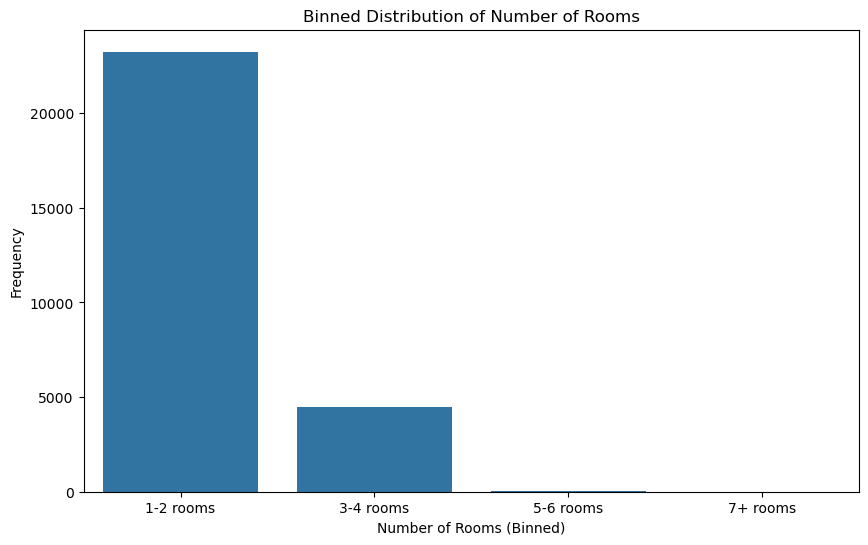

In [48]:
bins = [0, 2, 4, 6, float('inf')]
labels = ['1-2 rooms', '3-4 rooms', '5-6 rooms', '7+ rooms']

reduced_df['num_room_binned'] = pd.cut(reduced_df['num_room'], bins=bins, labels=labels)

plt.figure(figsize=(10, 6))
sns.countplot(data=reduced_df, x='num_room_binned')
plt.title('Binned Distribution of Number of Rooms')
plt.xlabel('Number of Rooms (Binned)')
plt.ylabel('Frequency')
plt.show()

num_room_binned
1-2 rooms    15.616696
3-4 rooms    16.057060
5-6 rooms    16.307716
7+ rooms     15.748776
Name: log_price_doc, dtype: float64


C:\Users\Цецо\AppData\Local\Temp\ipykernel_4228\3259506674.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_price_by_bin = reduced_df.groupby('num_room_binned')['log_price_doc'].mean()


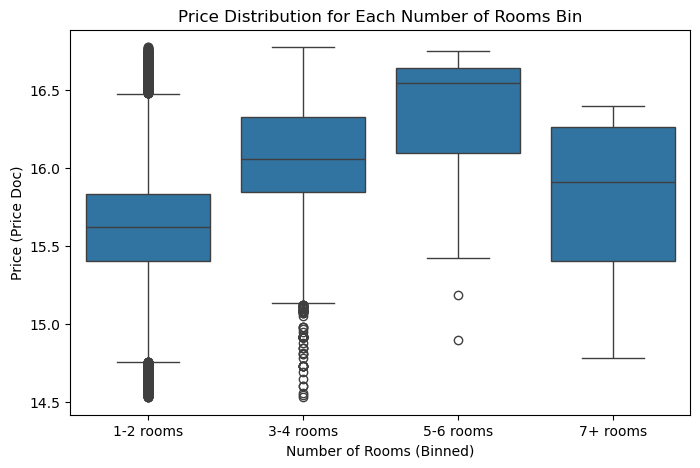

In [49]:
mean_price_by_bin = reduced_df.groupby('num_room_binned')['log_price_doc'].mean()

print(mean_price_by_bin)

plt.figure(figsize=(8, 5))
sns.boxplot(x='num_room_binned', y='log_price_doc', data=reduced_df)
plt.title('Price Distribution for Each Number of Rooms Bin')
plt.xlabel('Number of Rooms (Binned)')
plt.ylabel('Price (Price Doc)')
plt.show()

As expected, larger properties with more rooms tend to have higher prices. This confirms that the number of rooms is a good indicator of property price, and the binning has simplified the feature while still retaining useful information.

3. **Analysis of `raion_popul` (the number of municipality population per district)**: <br>
The histogram shows a right-skewed distribution, with most regions having smaller populations and a few with much larger populations. There are two distinct peaks around 50,000 and 100,000, indicating common population sizes. Additionally, there are outliers with very high population counts, likely representing large metropolitan areas. This uneven distribution may require further treatment for modeling.

In [50]:
reduced_df['raion_popul']

0        155572
1        115352
2        101708
3        178473
4        108171
          ...  
30465     75377
30466    175518
30468      4001
30469     78616
30470     94561
Name: raion_popul, Length: 27787, dtype: int64

In [51]:
raion_popul_stats = reduced_df['raion_popul'].describe()
print(raion_popul_stats)

count     27787.000000
mean      82386.377119
std       58563.180669
min        2546.000000
25%       21819.000000
50%       81980.000000
75%      118945.000000
max      247469.000000
Name: raion_popul, dtype: float64


I will check the skewness again to quantify the level of asymmetry in the distribution.

In [52]:
skewness_raion_popul = reduced_df['raion_popul'].skew()
print(f"Skewness of raion_popul: {skewness_raion_popul}")

Skewness of raion_popul: 0.4251301165631826


The skewness of is 0.43, which indicates a **slight positive skew**. Since it is not extreme, applying a transformation (e.g., logarithmic) may not be strictly necessary. The feature may already be suitable for modeling without transformation.

In [53]:
correlation_raion_popul = reduced_df[['raion_popul', 'log_price_doc']].corr()
print(correlation_raion_popul)

               raion_popul  log_price_doc
raion_popul       1.000000       0.319367
log_price_doc     0.319367       1.000000


A moderate positive correlation. I can suggest that districts with higher populations tend to have slightly higher property prices, but the relationship is not very strong.

In [54]:
grouped_raion_popul = reduced_df.groupby('sub_area').agg(
    raion_popul_mean=('raion_popul', 'mean'),
    raion_popul_median=('raion_popul', 'median'),
    raion_popul_sum=('raion_popul', 'sum'),
    raion_popul_count=('raion_popul', 'count')
).reset_index()

grouped_raion_popul_sorted = grouped_raion_popul.sort_values(by='raion_popul_sum', ascending=False)

In [55]:
grouped_raion_popul_sorted

sub_area  raion_popul_mean  raion_popul_median  \
65                           Mitino          178473.0            178473.0   
60                          Mar'ino          247469.0            247469.0   
38                   Juzhnoe Butovo          178264.0            178264.0   
82                         Otradnoe          175518.0            175518.0   
140                Vyhino-Zhulebino          219609.0            219609.0   
..                              ...               ...                 ...   
91          Poselenie Marushkinskoe            5740.0              5740.0   
88               Poselenie Kievskij            8384.0              8384.0   
99            Poselenie Shhapovskoe            7341.0              7341.0   
92   Poselenie Mihajlovo-Jarcevskoe            4949.0              4949.0   
66                  Molzhaninovskoe            3521.0              3521.0   

     raion_popul_sum  raion_popul_count  
65         118327599                663  
60         115073085                465  
38          71840392                403  
82          55112652                314  
140         52047333                237  
..               ...                ...  
91             22960                  4  
88             16768                  2  
99             14682                  2  
92              4949                  1  
66              3521                  1  

[145 rows x 5 columns]

The data shows stark contrasts in population distribution across districts. Urban areas like **Mitino**, **Mar'ino**, and **Juzhnoe Butovo** have the highest population sums and averages, indicating dense development. In contrast, districts like **Poselenie Mihajlovo-Jarcevskoe** and **Molzhaninovskoe** have much smaller populations, reflecting rural or less populated regions. The identical mean and median values in most areas suggest uniform population distributions within districts.

4. **Analysis of `full_sq`(total area in square meters) column**: <br> 
The histogram shows that the `full_sq` feature has a right-skewed distribution with a long tail. This suggests that most properties have smaller square footage, while a few properties with very large sizes create the skew. To improve the analysis, a logarithmic transformation can be applied to make the distribution more normal and reduce the impact of extreme values.

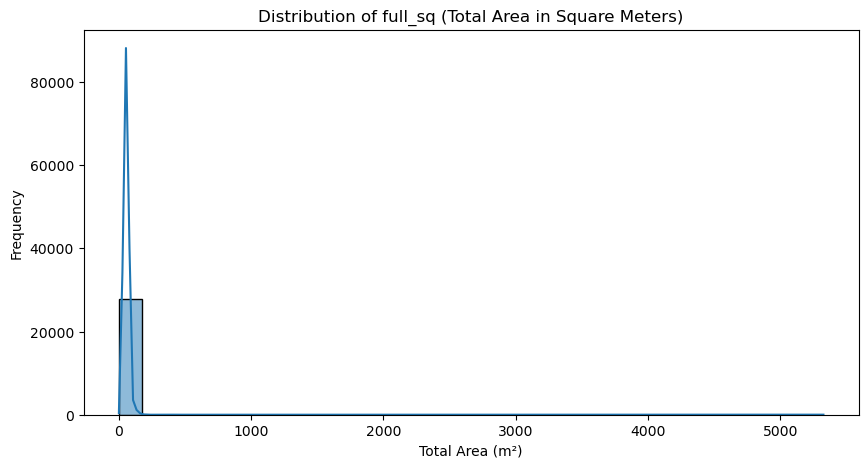

In [56]:
plt.figure(figsize=(10, 5))
sns.histplot(reduced_df['full_sq'], kde=True, bins=30)
plt.title('Distribution of full_sq (Total Area in Square Meters)')
plt.xlabel('Total Area (m²)')
plt.ylabel('Frequency')
plt.show()

In [57]:
print(f"Skewness of full_sq: {skew(reduced_df['full_sq'])}")

Skewness of full_sq: 96.81055183051927


The skewness of full_sq at **96.81 is extremely high**. Let's apply `logarithmic transformation`. It could reduce the impact of extremely large properties on the distribution, helping us achieve a more symmetric, normalized shape. But first of all - from the sctterplots I did before, I can see one outlier with value bigger than 5000. So let's remove it.

In [58]:
reduced_df = reduced_df[reduced_df['full_sq'] < 5000]

In [59]:
print(f"Skewness of full_sq: {skew(reduced_df['full_sq'])}")

Skewness of full_sq: 6.087224493162872


The skewness is 6.08 now, but the distribution of `full_s` is still seriously asymmetric.

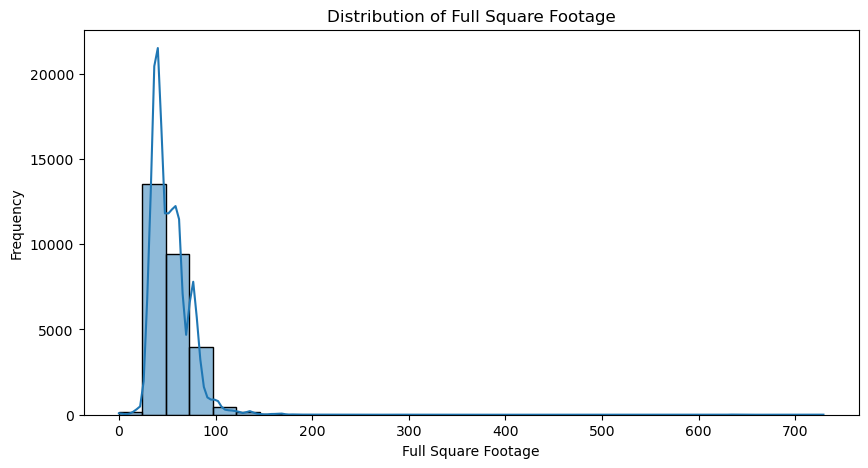

In [60]:
plt.figure(figsize=(10, 5))
sns.histplot(reduced_df['full_sq'], kde=True, bins=30)
plt.title('Distribution of Full Square Footage')
plt.xlabel('Full Square Footage')
plt.ylabel('Frequency')
plt.show()

Let's apply log-transformation.

In [61]:
reduced_df['log_full_sq'] = np.log1p(reduced_df['full_sq'])

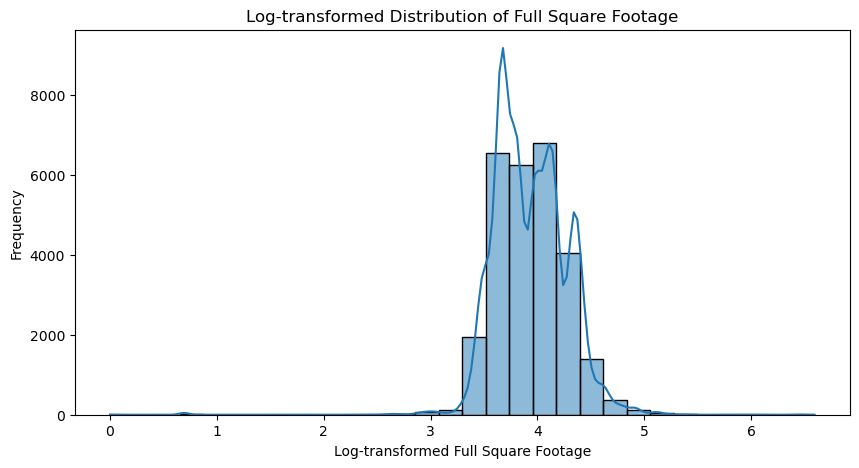

In [62]:
plt.figure(figsize=(10, 5))
sns.histplot(reduced_df['log_full_sq'], kde=True, bins=30)
plt.title('Log-transformed Distribution of Full Square Footage')
plt.xlabel('Log-transformed Full Square Footage')
plt.ylabel('Frequency')
plt.show()

Let's see the correlation before and after the log-transformation.

In [63]:
correlation_full_sq = reduced_df[['full_sq', 'log_price_doc']].corr()
print(correlation_full_sq)

                full_sq  log_price_doc
full_sq        1.000000       0.458887
log_price_doc  0.458887       1.000000


In [64]:
correlation_log_full_sq = reduced_df[['log_full_sq', 'price_doc']].corr()
print(correlation_log_full_sq)

             log_full_sq  price_doc
log_full_sq     1.000000   0.523561
price_doc       0.523561   1.000000


As we can see there is a noticeable improvement over the original correlation. This indicates a stronger positive relationship between the log-transformed square footage and the property price.

5. **Analysis of `prom_part_5000` (share of industrial zones in 5000 meters zone)**: <br>
The histogram of prom_part_5000 (share of industrial zones within a 5000-meter radius) reveals a right-skewed distribution, with most values concentrated at the lower end (between 0 and 15). The distribution has two peaks, around 5 and 10, indicating that these values are common among the observations. There are also a few outliers on the higher end, with values extending up to 25. These may represent areas with a significantly higher industrial presence.

In [65]:
reduced_df['prom_part_5000']

0        13.31
1        27.47
2        21.58
3         3.89
4        10.92
         ...  
30465     5.73
30466    17.24
30468     6.96
30469     9.33
30470    10.16
Name: prom_part_5000, Length: 27786, dtype: float64

In [66]:
prom_part_5000_stats = reduced_df['prom_part_5000'].describe()
print(prom_part_5000_stats)

count    27786.000000
mean        10.231183
std          5.673632
min          0.210000
25%          6.040000
50%          8.700000
75%         13.880000
max         28.560000
Name: prom_part_5000, dtype: float64


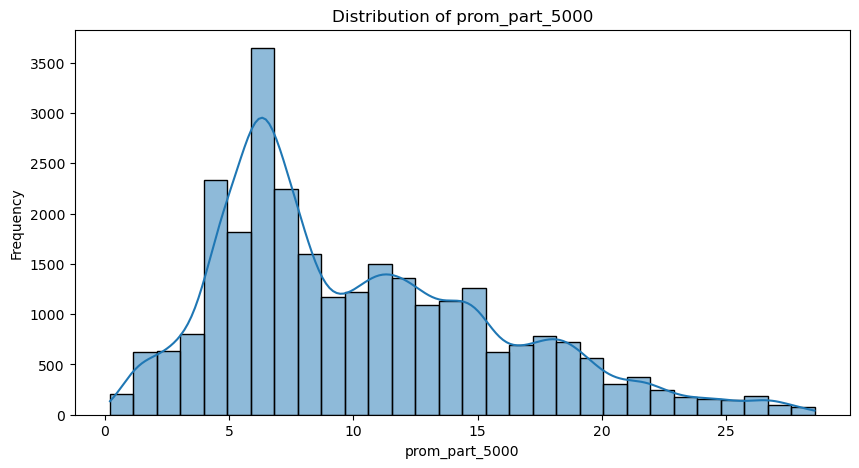

In [67]:
plt.figure(figsize=(10, 5))
sns.histplot(reduced_df['prom_part_5000'], kde=True, bins=30)
plt.title('Distribution of prom_part_5000')
plt.xlabel('prom_part_5000')
plt.ylabel('Frequency')
plt.show()

In [68]:
skewness_prom_part_5000 = reduced_df['prom_part_5000'].skew()
print(f"Skewness of prom_part_5000: {skewness_prom_part_5000}")

Skewness of prom_part_5000: 0.794686368982219


The skewness is **0.79**, which indicates a moderate positive skew. I don't think that any transformation is needed for now.

6. **Analysis of `build_count_block` (share of block buildings) column**: <br>
From the histogram, we can observe that `build_count_block` has an asymmetric distribution, with a large concentration of values at or near zero, followed by a tail extending to higher values. This suggests that while many areas have a minimal proportion of block buildings, there are a few regions with a significantly higher share. It is important to note that the zero values have real significance, indicating properties located in areas without block buildings.

In [69]:
reduced_df['build_count_block'].describe()

count    27786.000000
mean        40.504607
std         46.360466
min          0.000000
25%          3.000000
50%         25.000000
75%         59.000000
max        223.000000
Name: build_count_block, dtype: float64

In [70]:
build_count_block = skew(reduced_df['build_count_block'])
print(f"Skewness of build_count_block: {build_count_block}")

Skewness of build_count_block: 1.5632060341518255


The skewness value is **1.56**, indicating a moderate positive skew. This means that the distribution is asymmetric, with the tail extending towards higher values, which is consistent with the earlier observation from the histogram. The majority of values are concentrated at the lower end (close to zero), while a smaller number of properties have higher values, indicating a few areas with a significant presence of block buildings.

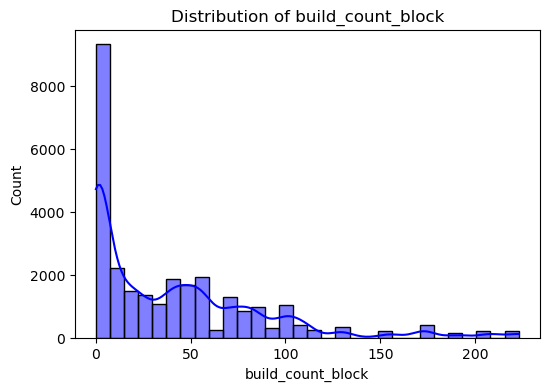

In [71]:
plt.figure(figsize=(6, 4))
sns.histplot(reduced_df['build_count_block'], bins=30, kde=True, color='blue')
plt.title('Distribution of build_count_block')
plt.show()

In [72]:
correlation_block = reduced_df[['build_count_block', 'log_price_doc']].corr()
print(correlation_block)

                   build_count_block  log_price_doc
build_count_block           1.000000       0.196781
log_price_doc               0.196781       1.000000


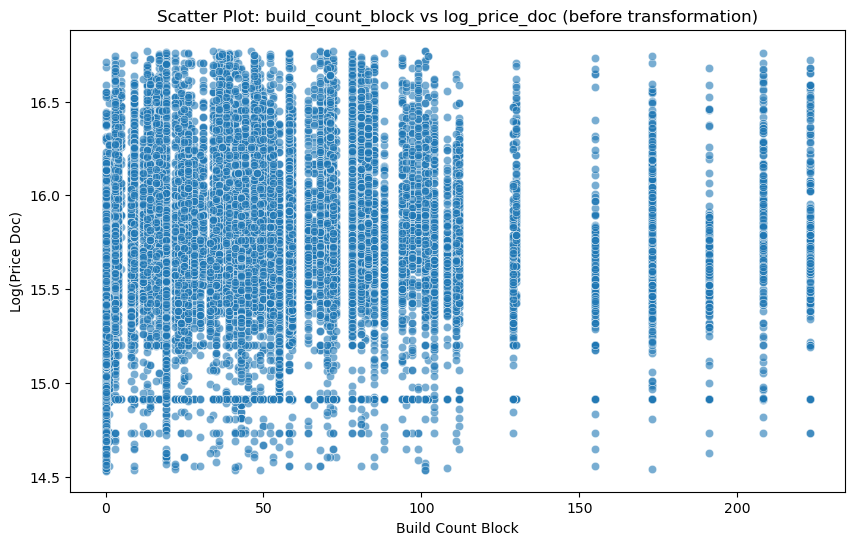

In [73]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced_df['build_count_block'], y=reduced_df['log_price_doc'], alpha=0.6)
plt.title('Scatter Plot: build_count_block vs log_price_doc (before transformation)')
plt.xlabel('Build Count Block')
plt.ylabel('Log(Price Doc)')
plt.show()

7. **Analysis of `shopping_centers_raion` (the number of malls and shopping centers in a district)**: <br>
The histogram shows a right-skewed distribution, with the majority of regions having few or no shopping centers. There are two prominent peaks, one around 0 and another around 5, suggesting that many districts either lack shopping centers or have only a small number. A few regions with significantly higher counts are apparent outliers, representing areas with a concentrated presence of shopping centers.

In [74]:
reduced_df['shopping_centers_raion'].unique()

array([16,  3,  0, 11, 10,  6,  5,  7,  2,  1,  9, 15,  4,  8, 19, 23],
      dtype=int64)

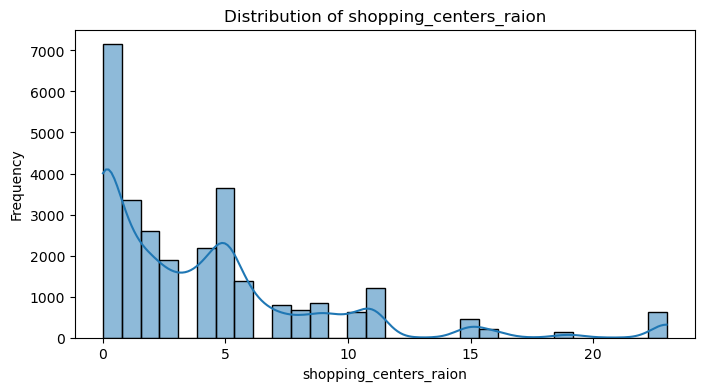

In [75]:
plt.figure(figsize=(8, 4))
sns.histplot(reduced_df['shopping_centers_raion'], kde=True, bins=30)
plt.title('Distribution of shopping_centers_raion')
plt.xlabel('shopping_centers_raion')
plt.ylabel('Frequency')
plt.show()

In [76]:
reduced_df['shopping_centers_raion'].value_counts()

shopping_centers_raion
0     7151
5     3642
1     3363
2     2587
4     2191
3     1899
6     1377
11    1203
9      848
7      801
8      661
23     635
10     624
15     465
16     205
19     134
Name: count, dtype: int64

The `shopping_centers_raion` column shows that the largest number of values are 0, meaning that many districts lack shopping centers entirely. 

In [77]:
shopping_centers_by_area = reduced_df.groupby('sub_area')['shopping_centers_raion'].agg(['mean', 'median', 'sum', 'count']).reset_index()
print(shopping_centers_by_area)

              sub_area  mean  median   sum  count
0            Ajeroport   3.0     3.0   330    110
1       Akademicheskoe   1.0     1.0   169    169
2         Alekseevskoe   0.0     0.0     0     88
3         Altuf'evskoe   3.0     3.0   162     54
4                Arbat   8.0     8.0    96     12
..                 ...   ...     ...   ...    ...
140   Vyhino-Zhulebino   8.0     8.0  1896    237
141     Zamoskvorech'e   5.0     5.0   160     32
142  Zapadnoe Degunino   5.0     5.0  1950    390
143         Zjablikovo   5.0     5.0   575    115
144            Zjuzino   2.0     2.0   436    218

[145 rows x 5 columns]


In [78]:
no_shopping_centers = shopping_centers_by_area[shopping_centers_by_area['sum'] == 0]
print(no_shopping_centers)

                           sub_area  mean  median  sum  count
2                      Alekseevskoe   0.0     0.0    0     88
7                           Begovoe   0.0     0.0    0     55
11               Birjulevo Zapadnoe   0.0     0.0    0    107
42                         Kapotnja   0.0     0.0    0     46
44                          Koptevo   0.0     0.0    0    183
45                 Kosino-Uhtomskoe   0.0     0.0    0    211
61                          Marfino   0.0     0.0    0     77
62                       Matushkino   0.0     0.0    0     88
64                     Metrogorodok   0.0     0.0    0     54
72                       Nekrasovka   0.0     0.0    0   1579
86           Poselenie Desjonovskoe   0.0     0.0    0    360
87         Poselenie Filimonkovskoe   0.0     0.0    0    471
88               Poselenie Kievskij   0.0     0.0    0      2
89             Poselenie Kokoshkino   0.0     0.0    0     16
90        Poselenie Krasnopahorskoe   0.0     0.0    0     25
91      

Sub-areas such as Arbat and Vyhino-Zhulebino have a higher average number of shopping centers, with a mean of 8.0, indicating these areas are more urbanized or commercialized. In contrast, some sub-areas, like Alekseevskoe, show a mean of 0.0, suggesting that there are no shopping centers in these areas, which could reflect residential or industrial zones with fewer commercial establishments.

Other sub-areas, such as Zamoskvorech'e and Zapadnoe Degunino, have a mean of around 5, indicating a moderate concentration of shopping centers. This variability across sub-areas suggests that shopping centers are more prevalent in certain commercial or densely populated regions, while suburban or less developed areas tend to have fewer shopping centers.

Now, I will analyze how the number of shopping centers in a region correlates with other regional attributes like population `(raion_popul)` or industrial zone share `(prom_part_5000)`.

In [79]:
correlation_with_areas = reduced_df.groupby('sub_area')[['shopping_centers_raion', 'raion_popul', 'prom_part_5000']].mean().corr()
print(correlation_with_areas)

                        shopping_centers_raion  raion_popul  prom_part_5000
shopping_centers_raion                1.000000     0.509494        0.242924
raion_popul                           0.509494     1.000000        0.263864
prom_part_5000                        0.242924     0.263864        1.000000


1. Shopping Centers and Raion Population (0.51): <br>
There is a moderate positive correlation. This indicates that districts with larger populations tend to have more shopping centers, as higher populations usually create greater demand for retail spaces.
2. Shopping Centers and Share of Industrial Zones (0.24): <br>
Relatively low but positive correlation. While areas with more industrial zones may have some shopping centers, the presence of industrial zones does not strongly determine the number of shopping centers.

In [80]:
# TO-DO?
#Cluster Sub-Areas:
#Perform clustering based on features like shopping_centers_raion, raion_popul, 
#and others to group similar areas together (e.g., urban, suburban, rural).

8. **Analysis of `sport_objects_raion` (the number of sports facilities or objects within a district)**: <br>
The histogram shows a right-skewed distribution. The majority of districts have only a few sports objects, with a prominent peak around the 0-5 range. A smaller number of districts have higher counts, which are less frequent as the values increase. This uneven distribution suggests that sports facilities are concentrated in a limited number of regions, with many districts having relatively few or none.

In [81]:
reduced_df['sport_objects_raion']

0         7
1         6
2         5
3        17
4        25
         ..
30465    29
30466    10
30468     0
30469    11
30470     7
Name: sport_objects_raion, Length: 27786, dtype: int64

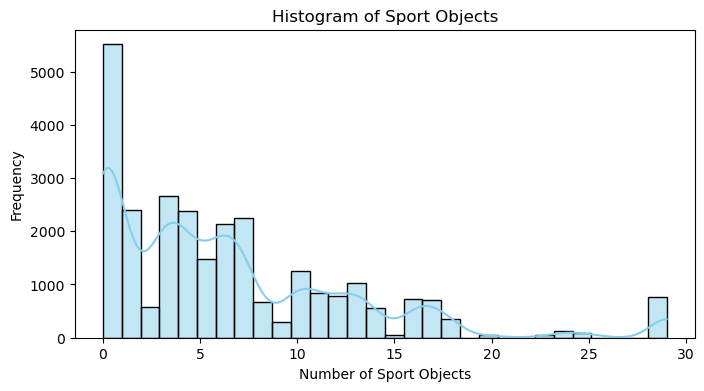

In [82]:
plt.figure(figsize=(8, 4))
sns.histplot(reduced_df['sport_objects_raion'], kde=True, bins=30, color='skyblue')
plt.title('Histogram of Sport Objects')
plt.xlabel('Number of Sport Objects')
plt.ylabel('Frequency')
plt.show()

In [83]:
skewness = skew(reduced_df['sport_objects_raion'])
print(f"Skewness of 'sport_objects_raion': {skewness}")

Skewness of 'sport_objects_raion': 1.4704907148260675


In [84]:
correlation = reduced_df[['sport_objects_raion', 'log_price_doc']].corr()
print("Correlation with log_price_doc:\n", correlation)

Correlation with log_price_doc:
                      sport_objects_raion  log_price_doc
sport_objects_raion             1.000000       0.279394
log_price_doc                   0.279394       1.000000


In [85]:
grouped_sub_area = reduced_df.groupby('sub_area')['sport_objects_raion'].agg(['mean', 'median', 'sum', 'count'])
sorted_sports_objects = grouped_sub_area.sort_values(by='sum', ascending=False)

In [86]:
print(sorted_sports_objects)

                          mean  median    sum  count
sub_area                                            
Tverskoe                  29.0    29.0  18415    635
Mitino                    17.0    17.0  11271    663
Mar'ino                   16.0    16.0   7440    465
Juzhnoe Butovo            13.0    13.0   5239    403
Izmajlovo                 16.0    16.0   4096    256
...                        ...     ...    ...    ...
Poselenie Kievskij         0.0     0.0      0      2
Poselenie Filimonkovskoe   0.0     0.0      0    471
Poselenie Desjonovskoe     0.0     0.0      0    360
Silino                     0.0     0.0      0     85
Nekrasovka                 0.0     0.0      0   1579

[145 rows x 4 columns]


Urban areas like Tverskoe and Mitino have more sports facilities, while rural areas such as Poselenie Kievskij report none. The number of data points per sub-area also varies, which may affect the reliability of the results.

9. **Analysis of `raion_build_count_with_material_info` (Number of Buildings with Material Info in District)**: <br>
The histogram for raion_build_count_with_material_info (the number of buildings with material information in a district) reveals a right-skewed distribution, with most districts having few or no buildings with available material information. There is a prominent peak at 0, indicating many districts have either no recorded building materials or a very small number. Additionally, a few districts have a high number of buildings with material data, which are likely outliers, pointing to areas with more detailed building records, possibly in urban or industrial zones.

In [87]:
reduced_df['raion_build_count_with_material_info']

0        211.0
1        245.0
2        330.0
3        458.0
4        746.0
         ...  
30465    651.0
30466    282.0
30468      0.0
30469    185.0
30470    304.0
Name: raion_build_count_with_material_info, Length: 27786, dtype: float64

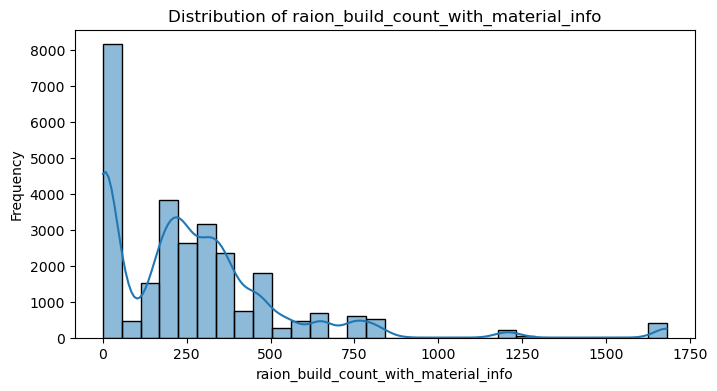

In [88]:
plt.figure(figsize=(8, 4))
sns.histplot(reduced_df['raion_build_count_with_material_info'], kde=True, bins=30)
plt.title('Distribution of raion_build_count_with_material_info')
plt.xlabel('raion_build_count_with_material_info')
plt.ylabel('Frequency')
plt.show()

In [89]:
reduced_df[reduced_df['raion_build_count_with_material_info'] == 0].shape[0]

4917

In [90]:
grouped_by_sub_area = reduced_df.groupby('sub_area')['raion_build_count_with_material_info'].agg(
    ['mean', 'median', 'sum', 'count']).reset_index()

grouped_by_sub_area_sorted = grouped_by_sub_area.sort_values(by='mean', ascending=False)

In [91]:
grouped_by_sub_area_sorted

sub_area    mean  median       sum  count
38             Juzhnoe Butovo  1681.0  1681.0  677443.0    403
135                   Vnukovo  1233.0  1233.0   49320.0     40
45           Kosino-Uhtomskoe  1204.0  1204.0  254044.0    211
66            Molzhaninovskoe   866.0   866.0     866.0      1
106               Presnenskoe   836.0   836.0  105336.0    126
..                        ...     ...     ...       ...    ...
102      Poselenie Vnukovskoe     0.0     0.0       0.0   1371
88         Poselenie Kievskij     0.0     0.0       0.0      2
87   Poselenie Filimonkovskoe     0.0     0.0       0.0    471
86     Poselenie Desjonovskoe     0.0     0.0       0.0    360
104   Poselenie Voskresenskoe     0.0     0.0       0.0    712

[145 rows x 5 columns]

10. **Analysis of `cafe_sum_1000_min_price_avg`, `cafe_sum_1500_min_price_avg`, `cafe_sum_500_min_price_avg` and `cafe_sum_2000_min_price_avg`** columns: <br>
The histograms reveal right-skewed distributions, with most values concentrated at lower price ranges and a small number of areas with significantly higher average minimum prices. This skewness suggests that while the majority of neighborhoods have cafes with relatively low prices, there are exceptions with much higher values.

In [92]:
cafe_columns = [
    'cafe_sum_1000_min_price_avg', 
    'cafe_sum_1500_min_price_avg', 
    'cafe_sum_500_min_price_avg', 
    'cafe_sum_2000_min_price_avg'
]

Analyzing column: cafe_sum_1000_min_price_avg


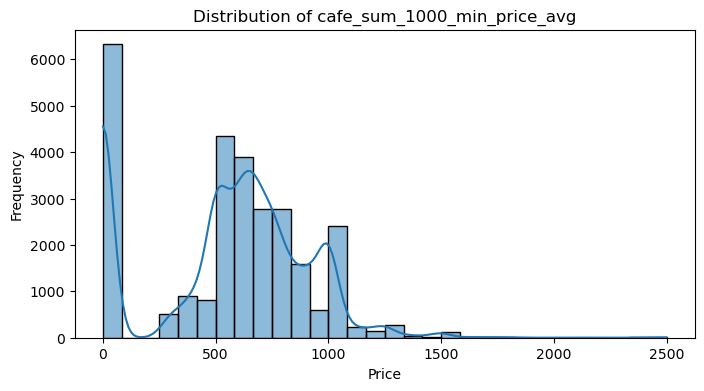

Skewness of cafe_sum_1000_min_price_avg: -0.12263007264321114
Correlation of cafe_sum_1000_min_price_avg with price_doc:
                             cafe_sum_1000_min_price_avg  log_price_doc
cafe_sum_1000_min_price_avg                     1.000000       0.297784
log_price_doc                                   0.297784       1.000000

Analyzing column: cafe_sum_1500_min_price_avg


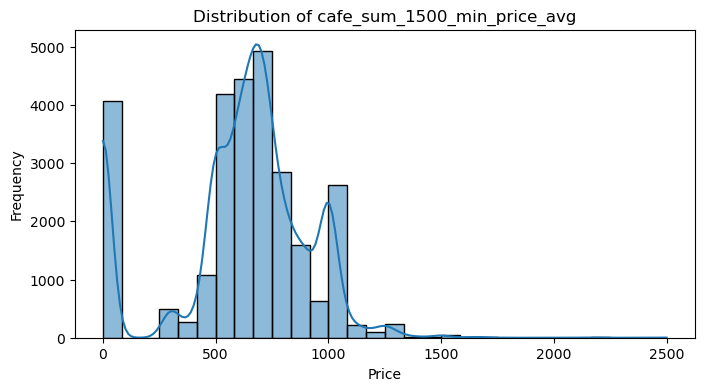

Skewness of cafe_sum_1500_min_price_avg: -0.5720692332610627
Correlation of cafe_sum_1500_min_price_avg with price_doc:
                             cafe_sum_1500_min_price_avg  log_price_doc
cafe_sum_1500_min_price_avg                     1.000000       0.277545
log_price_doc                                   0.277545       1.000000

Analyzing column: cafe_sum_500_min_price_avg


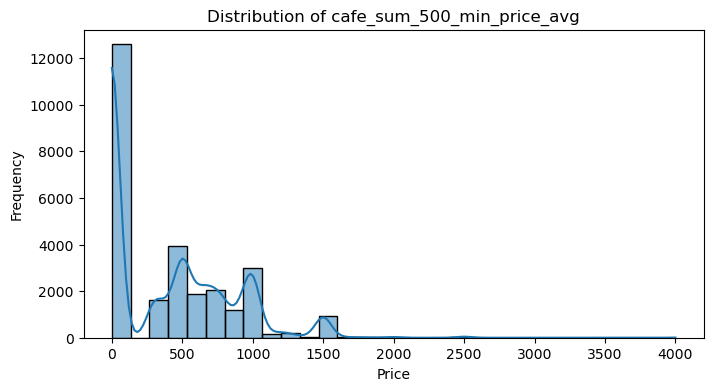

Skewness of cafe_sum_500_min_price_avg: 0.9834802843702928
Correlation of cafe_sum_500_min_price_avg with price_doc:
                            cafe_sum_500_min_price_avg  log_price_doc
cafe_sum_500_min_price_avg                    1.000000       0.231466
log_price_doc                                 0.231466       1.000000

Analyzing column: cafe_sum_2000_min_price_avg


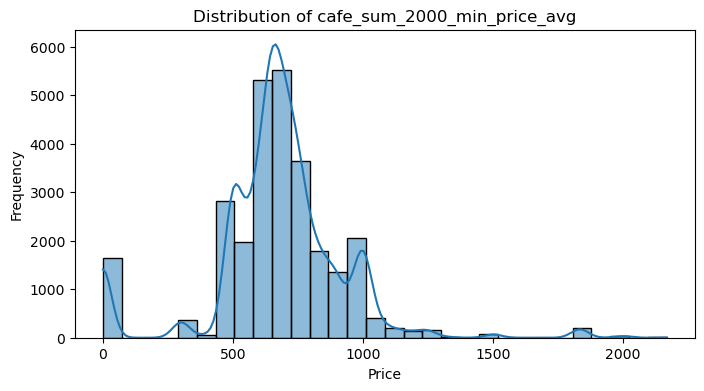

Skewness of cafe_sum_2000_min_price_avg: 0.17936086006402616
Correlation of cafe_sum_2000_min_price_avg with price_doc:
                             cafe_sum_2000_min_price_avg  log_price_doc
cafe_sum_2000_min_price_avg                     1.000000       0.209097
log_price_doc                                   0.209097       1.000000



In [93]:
for col in cafe_columns:
    print(f"Analyzing column: {col}")
    
    plt.figure(figsize=(8, 4))
    sns.histplot(reduced_df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel('Price')
    plt.ylabel('Frequency')
    plt.show()

    skewness = skew(reduced_df[col].dropna())
    print(f"Skewness of {col}: {skewness}")

    correlation = reduced_df[[col, 'log_price_doc']].corr()
    print(f"Correlation of {col} with price_doc:\n{correlation}\n")
    

Looking at the analysis I did for the four columns I can draw the following conclusions:
1. The skewness analysis of the cafe price columns reveals that cafe_sum_1000_min_price_avg has a minimal negative skew (-0.123), indicating a nearly symmetric distribution. cafe_sum_1500_min_price_avg shows a more pronounced negative skew (-0.572), suggesting the presence of higher values at the tail of the distribution. In contrast, cafe_sum_500_min_price_avg exhibits a significant positive skew (0.983), pointing to a distribution with a long tail toward higher values, while cafe_sum_2000_min_price_avg displays a small positive skew (0.179), indicating a nearly symmetric distribution with a slight tendency toward higher values.
2. In terms of correlation with log_price_doc, all columns show weak positive correlations, with values ranging from 0.21 to 0.30. The highest correlation is observed for cafe_sum_1000_min_price_avg (0.30), followed closely by cafe_sum_1500_min_price_avg (0.28). The correlation for cafe_sum_500_min_price_avg is slightly lower (0.23), while the lowest is for cafe_sum_2000_min_price_avg (0.21).

To simplify the analysis and reveal potential patterns, the next step will involve binning each cafe price column into categories such as "low", "medium", and "high" based on percentile ranges. This will reduce the impact of extreme values and make it easier to assess relationships with property prices. After binning, I will evaluate the average property price within each category to explore any clear trends.

In [94]:
for column in cafe_columns:
    bins = [reduced_df[column].min() - 1, 
            reduced_df[column].quantile(0.33), 
            reduced_df[column].quantile(0.66), 
            reduced_df[column].max()]
    
labels = ['Low', 'Medium', 'High']

for column in ['cafe_sum_1000_min_price_avg', 
               'cafe_sum_1500_min_price_avg', 
               'cafe_sum_500_min_price_avg', 
               'cafe_sum_2000_min_price_avg']:
    reduced_df[f'{column}_binned'] = pd.cut(reduced_df[column], bins=bins, labels=labels)

reduced_df[[f'{col}_binned' for col in ['cafe_sum_1000_min_price_avg', 
                                        'cafe_sum_1500_min_price_avg', 
                                        'cafe_sum_500_min_price_avg', 
                                        'cafe_sum_2000_min_price_avg']]].head()

cafe_sum_1000_min_price_avg_binned cafe_sum_1500_min_price_avg_binned  \
0                                Low                                Low   
1                                Low                             Medium   
2                             Medium                                Low   
3                             Medium                             Medium   
4                               High                               High   

  cafe_sum_500_min_price_avg_binned cafe_sum_2000_min_price_avg_binned  
0                               Low                                Low  
1                              High                             Medium  
2                            Medium                                Low  
3                              High                             Medium  
4                            Medium                               High

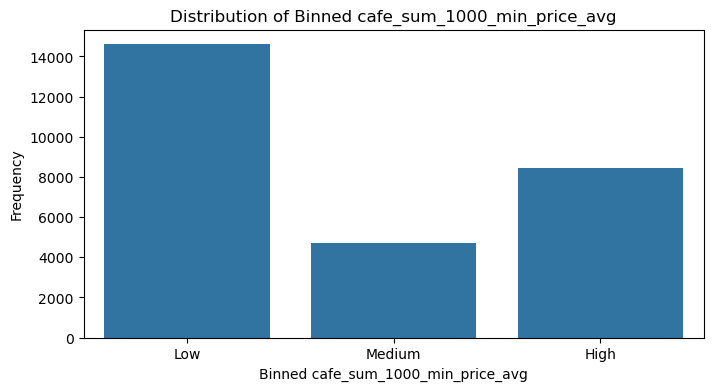

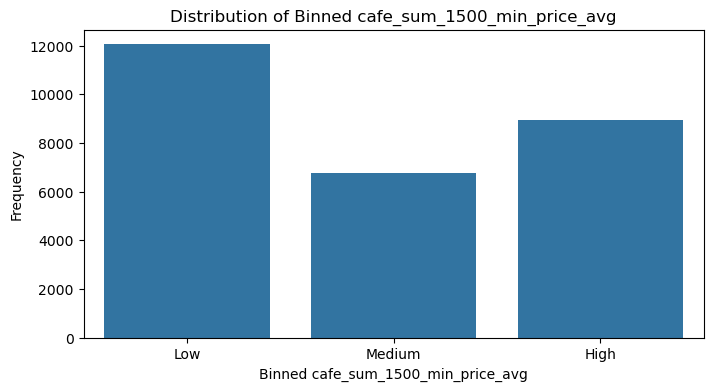

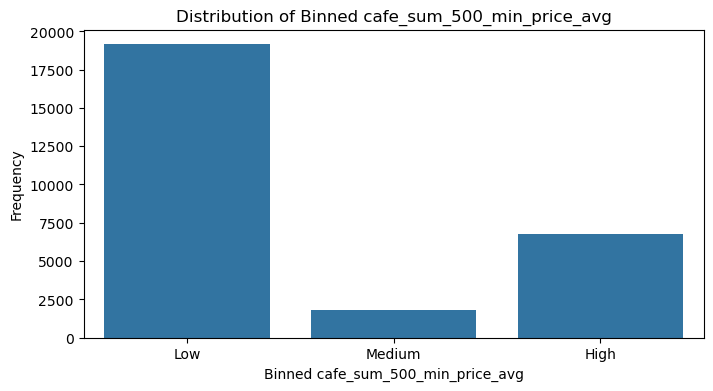

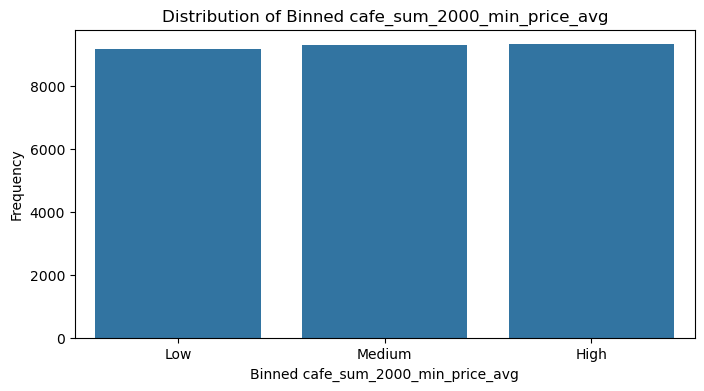

In [95]:
for column in cafe_columns:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=reduced_df[f'{column}_binned'])
    plt.title(f'Distribution of Binned {column}')
    plt.xlabel(f'Binned {column}')
    plt.ylabel('Frequency')
    plt.show()

Next, I will calculate the average property price for each of the bins in order to understand the relationship between the categorized cafe prices and property prices.

In [96]:
for column in cafe_columns:
    correlation_binned = reduced_df[[f'{column}_binned', 'log_price_doc']].groupby(f'{column}_binned')['log_price_doc'].mean()
    print(correlation_binned)

cafe_sum_1000_min_price_avg_binned
Low       15.595183
Medium    15.813132
High      15.780735
Name: log_price_doc, dtype: float64
cafe_sum_1500_min_price_avg_binned
Low       15.588403
Medium    15.764030
High      15.766851
Name: log_price_doc, dtype: float64
cafe_sum_500_min_price_avg_binned
Low       15.641865
Medium    15.843018
High      15.778752
Name: log_price_doc, dtype: float64
cafe_sum_2000_min_price_avg_binned
Low       15.570564
Medium    15.739892
High      15.754022
Name: log_price_doc, dtype: float64


C:\Users\Цецо\AppData\Local\Temp\ipykernel_4228\1770396517.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  correlation_binned = reduced_df[[f'{column}_binned', 'log_price_doc']].groupby(f'{column}_binned')['log_price_doc'].mean()
C:\Users\Цецо\AppData\Local\Temp\ipykernel_4228\1770396517.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  correlation_binned = reduced_df[[f'{column}_binned', 'log_price_doc']].groupby(f'{column}_binned')['log_price_doc'].mean()
C:\Users\Цецо\AppData\Local\Temp\ipykernel_4228\1770396517.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to T

The results show how property prices vary across the cafe price bins in the surrounding areas. The trend suggests that areas with higher average cafe prices are generally associated with higher property prices.

11. **Analysis of `healthcare_centers_raion` (the number of healthcare centers in a district)**: <br>
The histogram reveals a right-skewed distribution, with a majority of regions having a small number of healthcare centers. There is a prominent peak at the lower end of the distribution, around 0, indicating that many districts have few or no healthcare centers. A few smaller peaks are visible at higher values, suggesting that some areas have a more significant presence of healthcare facilities. This uneven distribution highlights disparities in healthcare access across different regions.

In [97]:
reduced_df['healthcare_centers_raion'].unique()

array([1, 4, 0, 3, 2, 5, 6], dtype=int64)

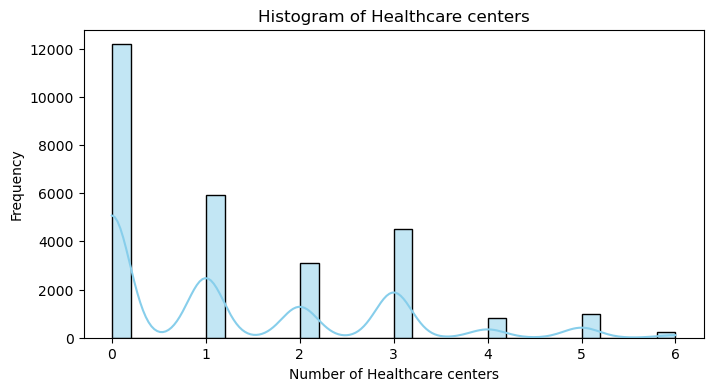

In [98]:
plt.figure(figsize=(8, 4))
sns.histplot(reduced_df['healthcare_centers_raion'], kde=True, bins=30, color='skyblue')
plt.title('Histogram of Healthcare centers')
plt.xlabel('Number of Healthcare centers')
plt.ylabel('Frequency')
plt.show()

In [99]:
print(f"Skewness of 'healthcare_centers_raion': {skew(reduced_df['healthcare_centers_raion'])}")

Skewness of 'healthcare_centers_raion': 1.0407660372500185


As next step, It's important to check how the variable correlates with the target variable, log_price_doc.

In [100]:
correlation = reduced_df[['healthcare_centers_raion', 'log_price_doc']].corr()
print(f"Correlation between 'healthcare_centers_raion' and log_price_doc:\n{correlation}\n")

Correlation between 'healthcare_centers_raion' and log_price_doc:
                          healthcare_centers_raion  log_price_doc
healthcare_centers_raion                  1.000000       0.264538
log_price_doc                             0.264538       1.000000



And now with other variables.

In [101]:
correlations = reduced_df[['healthcare_centers_raion', 'raion_popul', 'shopping_centers_raion', 'sport_objects_raion']].corr()

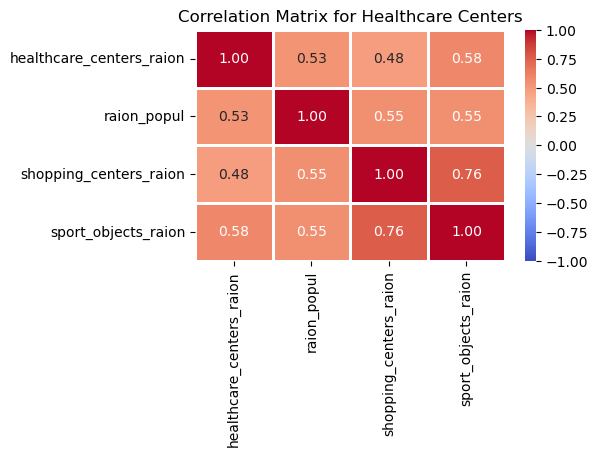

In [102]:
plt.figure(figsize=(5, 3))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt='.2f', linewidths=1, vmin=-1, vmax=1)
plt.title('Correlation Matrix for Healthcare Centers')
plt.show()

The correlation matrix reveals the following key insights:

1. Healthcare centers are moderately correlated with raion_popul (0.53), indicating that regions with larger populations tend to have more healthcare centers.
2. There is a moderate positive correlation between healthcare_centers_raion and sport_objects_raion (0.58), suggesting that regions with more sports facilities also tend to have more healthcare centers.
3. Shopping centers show a similar trend, with a moderate correlation (0.48) to healthcare centers, pointing to a possible link between commercial and healthcare infrastructure in more developed areas.

12. **Analysis of `market_count_3000` (number of markets in 3000 meters zone):** <br>
The histogram indicates that most regions have relatively few markets within a 3000-meter radius, with only a few regions showing higher concentrations of markets. This right-skewed distribution is common in count-based data and suggests that markets are not evenly distributed across all areas.

In [103]:
reduced_df['market_count_3000'].unique()

array([ 1,  6,  3,  5,  7,  2,  0,  4,  8, 10,  9], dtype=int64)

The column contains discrete values.

In [104]:
market_count_values = reduced_df['market_count_3000'].value_counts().sort_index()
market_count_values

market_count_3000
0     8814
1     4634
2     3535
3     2997
4     2244
5     2196
6     1926
7      835
8      514
9       84
10       7
Name: count, dtype: int64

In [105]:
reduced_df['market_count_3000'].describe()

count    27786.000000
mean         2.266969
std          2.279748
min          0.000000
25%          0.000000
50%          2.000000
75%          4.000000
max         10.000000
Name: market_count_3000, dtype: float64

C:\Users\Цецо\AppData\Local\Temp\ipykernel_4228\1086508503.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=market_count_values.index, y=market_count_values.values, palette="Blues_d")


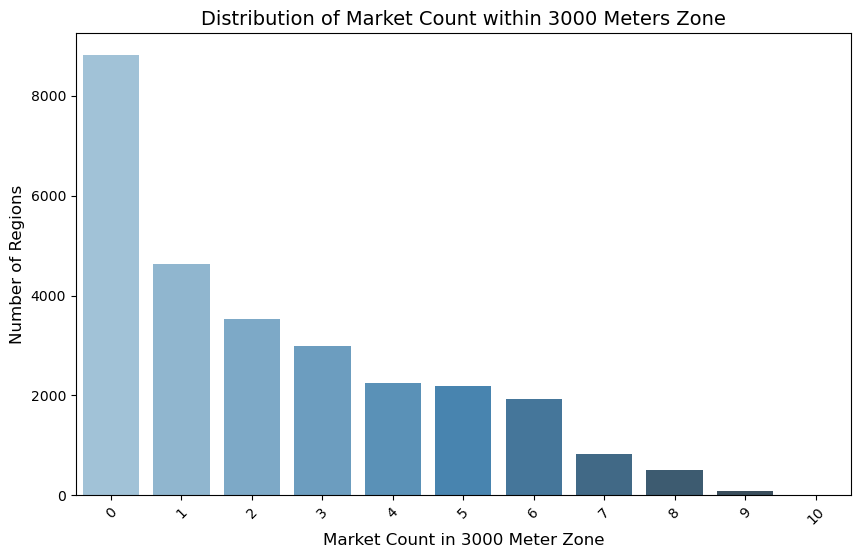

In [106]:
plt.figure(figsize=(10, 6))
sns.barplot(x=market_count_values.index, y=market_count_values.values, palette="Blues_d")
plt.title('Distribution of Market Count within 3000 Meters Zone', fontsize=14)
plt.xlabel('Market Count in 3000 Meter Zone', fontsize=12)
plt.ylabel('Number of Regions', fontsize=12)
plt.xticks(rotation=45)
plt.show()

In [107]:
market_correlations = reduced_df[['market_count_3000', 'raion_popul', 'shopping_centers_raion', 'sport_objects_raion', 'healthcare_centers_raion']].corr()

In [108]:
market_correlations

market_count_3000  raion_popul  \
market_count_3000                  1.000000     0.451305   
raion_popul                        0.451305     1.000000   
shopping_centers_raion             0.446389     0.547061   
sport_objects_raion                0.462994     0.552201   
healthcare_centers_raion           0.469380     0.525394   

                          shopping_centers_raion  sport_objects_raion  \
market_count_3000                       0.446389             0.462994   
raion_popul                             0.547061             0.552201   
shopping_centers_raion                  1.000000             0.758752   
sport_objects_raion                     0.758752             1.000000   
healthcare_centers_raion                0.480509             0.578871   

                          healthcare_centers_raion  
market_count_3000                         0.469380  
raion_popul                               0.525394  
shopping_centers_raion                    0.480509  
sport_objects_raion                       0.578871  
healthcare_centers_raion                  1.000000

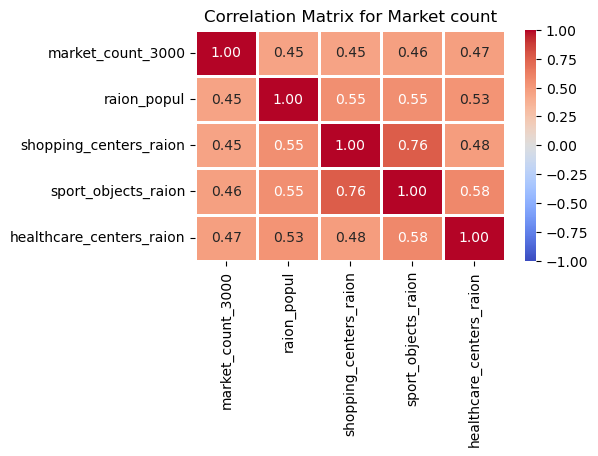

In [109]:
plt.figure(figsize=(5, 3))
sns.heatmap(market_correlations, annot=True, cmap='coolwarm', fmt='.2f', linewidths=1, vmin=-1, vmax=1)
plt.title('Correlation Matrix for Market count')
plt.show()

13. **Analysis of `market_count_5000`**: <br>
The column represents the number of markets within a 5000-meter radius in each district. The histogram for this column indicates the distribution of market counts across various districts or regions. The data is right-skewed, with the majority of districts having fewer markets. A few districts have significantly higher market counts, which may indicate more densely populated or more commercially developed areas.

In [110]:
reduced_df['market_count_5000'].unique()

array([ 4, 14, 10,  3, 17,  8, 11,  6,  0,  7, 13, 12,  5,  9,  2, 18,  1,
       16, 19, 15, 20, 21], dtype=int64)

In [111]:
market_count_5000_values = reduced_df['market_count_5000'].value_counts().sort_index()
market_count_5000_values

market_count_5000
0     3995
1     4159
2     1550
3     1500
4     1976
5     2299
6     1252
7     1213
8     1024
9      965
10    1225
11    1395
12    1573
13    1876
14     800
15     415
16     238
17     150
18     127
19      37
20      16
21       1
Name: count, dtype: int64

C:\Users\Цецо\AppData\Local\Temp\ipykernel_4228\2679857450.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=market_count_5000_values.index, y=market_count_5000_values.values, palette="Blues_d")


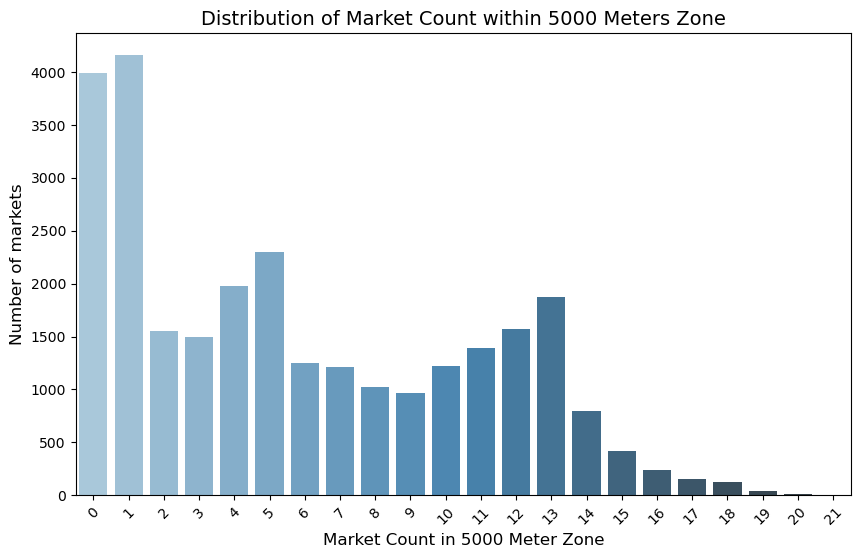

In [112]:
plt.figure(figsize=(10, 6))
sns.barplot(x=market_count_5000_values.index, y=market_count_5000_values.values, palette="Blues_d")
plt.title('Distribution of Market Count within 5000 Meters Zone', fontsize=14)
plt.xlabel('Market Count in 5000 Meter Zone', fontsize=12)
plt.ylabel('Number of markets', fontsize=12)
plt.xticks(rotation=45)
plt.show()

In [113]:
market_count_5000_grouped = reduced_df.groupby('sub_area')['market_count_5000'].describe()
print("Summary statistics for 'market_count_5000' by sub_area:")
market_count_5000_grouped

Summary statistics for 'market_count_5000' by sub_area:


count       mean       std   min   25%   50%    75%   max
sub_area                                                                    
Ajeroport          110.0  13.736364  0.672900  12.0  13.0  14.0  14.00  15.0
Akademicheskoe     169.0   9.449704  1.194787   5.0   9.0   9.0  10.00  13.0
Alekseevskoe        88.0   8.227273  2.242368   4.0   6.0   8.0  10.25  11.0
Altuf'evskoe        54.0   5.000000  0.000000   5.0   5.0   5.0   5.00   5.0
Arbat               12.0  10.000000  1.809068   8.0   9.0  10.0  10.00  14.0
...                  ...        ...       ...   ...   ...   ...    ...   ...
Vyhino-Zhulebino   237.0   7.240506  2.586873   4.0   5.0   7.0   8.00  15.0
Zamoskvorech'e      32.0  13.875000  1.313700  12.0  13.0  13.0  15.00  17.0
Zapadnoe Degunino  390.0   4.330769  1.165408   3.0   4.0   4.0   4.00   9.0
Zjablikovo         115.0  10.200000  0.870572   9.0   9.0  10.0  11.00  11.0
Zjuzino            218.0  11.399083  0.864774   9.0  11.0  12.0  12.00  12.0

[145 rows x 8 columns]

14. **Analysis of `sport_count_1000` (number of sport facilities in 1000 meters zone)**: <br>
The data is right-skewed, with the majority of districts having fewer markets. A few districts have significantly higher market counts, which may indicate more densely populated or more commercially developed areas.

In [114]:
reduced_df['sport_count_1000'].unique()

array([ 6,  2,  5,  3,  7,  1,  0,  8,  4, 10, 14,  9, 11, 13, 16, 17, 12,
       15, 25, 19, 18, 21], dtype=int64)

In [115]:
sport_count_1000_values = reduced_df['sport_count_1000'].value_counts()
sport_count_1000_values

sport_count_1000
0     8310
1     4480
2     3154
3     2813
4     2419
5     2408
6     1398
7      804
16     608
8      473
9      328
10     209
11     148
12      70
14      55
13      46
15      31
17      18
19       6
18       6
25       1
21       1
Name: count, dtype: int64

C:\Users\Цецо\AppData\Local\Temp\ipykernel_4228\3001850267.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sport_count_1000_values.index, y=sport_count_1000_values.values, palette="Blues_d")


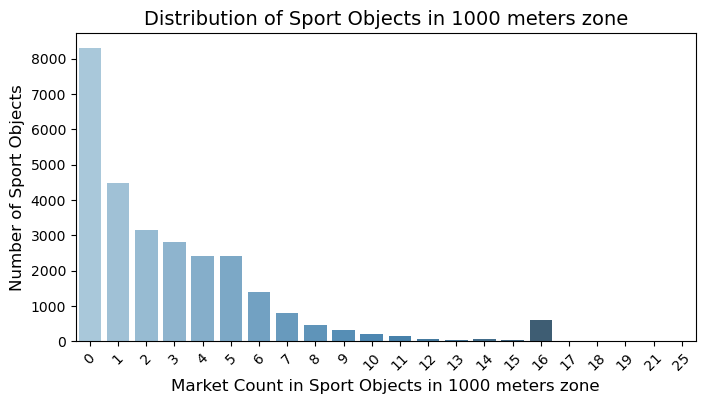

In [116]:
plt.figure(figsize=(8, 4))
sns.barplot(x=sport_count_1000_values.index, y=sport_count_1000_values.values, palette="Blues_d")
plt.title('Distribution of Sport Objects in 1000 meters zone', fontsize=14)
plt.xlabel('Market Count in Sport Objects in 1000 meters zone', fontsize=12)
plt.ylabel('Number of Sport Objects', fontsize=12)
plt.xticks(rotation=45)
plt.show()

In [117]:
correlations_sport_1000 = reduced_df[['sport_count_1000', 'raion_popul', 'shopping_centers_raion', 'market_count_3000', 'healthcare_centers_raion']].corr()
print("Correlation Matrix:")
correlations_sport_1000

Correlation Matrix:


sport_count_1000  raion_popul  \
sport_count_1000                  1.000000     0.341376   
raion_popul                       0.341376     1.000000   
shopping_centers_raion            0.617437     0.547061   
market_count_3000                 0.450285     0.451305   
healthcare_centers_raion          0.432780     0.525394   

                          shopping_centers_raion  market_count_3000  \
sport_count_1000                        0.617437           0.450285   
raion_popul                             0.547061           0.451305   
shopping_centers_raion                  1.000000           0.446389   
market_count_3000                       0.446389           1.000000   
healthcare_centers_raion                0.480509           0.469380   

                          healthcare_centers_raion  
sport_count_1000                          0.432780  
raion_popul                               0.525394  
shopping_centers_raion                    0.480509  
market_count_3000                         0.469380  
healthcare_centers_raion                  1.000000

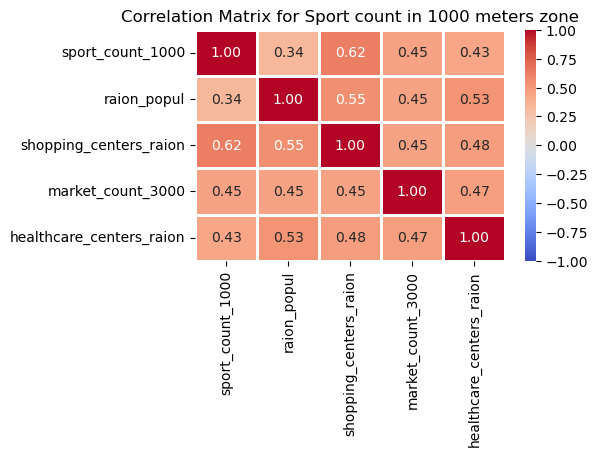

In [118]:
plt.figure(figsize=(5, 3))
sns.heatmap(correlations_sport_1000, annot=True, cmap='coolwarm', fmt='.2f', linewidths=1, vmin=-1, vmax=1)
plt.title('Correlation Matrix for Sport count in 1000 meters zone')
plt.show()

In [119]:
sport_count_1000_grouped = reduced_df.groupby('sub_area')['sport_count_1000'].describe()
print("Summary Statistics for 'sport_count_1000' by sub_area:")
sport_count_1000_grouped

Summary Statistics for 'sport_count_1000' by sub_area:


count      mean       std  min  25%  50%   75%   max
sub_area                                                               
Ajeroport          110.0  5.145455  3.701813  1.0  2.0  4.0   7.0  21.0
Akademicheskoe     169.0  3.396450  1.292003  0.0  3.0  3.0   4.0   7.0
Alekseevskoe        88.0  5.659091  1.999347  1.0  4.0  6.0   7.0   8.0
Altuf'evskoe        54.0  2.962963  0.910380  1.0  2.0  3.0   4.0   5.0
Arbat               12.0  8.750000  2.261335  5.0  7.0  8.5  11.0  12.0
...                  ...       ...       ...  ...  ...  ...   ...   ...
Vyhino-Zhulebino   237.0  2.156118  1.002589  0.0  1.0  2.0   3.0   4.0
Zamoskvorech'e      32.0  9.906250  2.569792  6.0  8.0  9.5  12.0  15.0
Zapadnoe Degunino  390.0  1.148718  0.803870  0.0  1.0  1.0   1.0   4.0
Zjablikovo         115.0  4.617391  1.804393  1.0  3.5  5.0   6.0   8.0
Zjuzino            218.0  2.449541  1.468478  0.0  2.0  2.0   4.0   6.0

[145 rows x 8 columns]

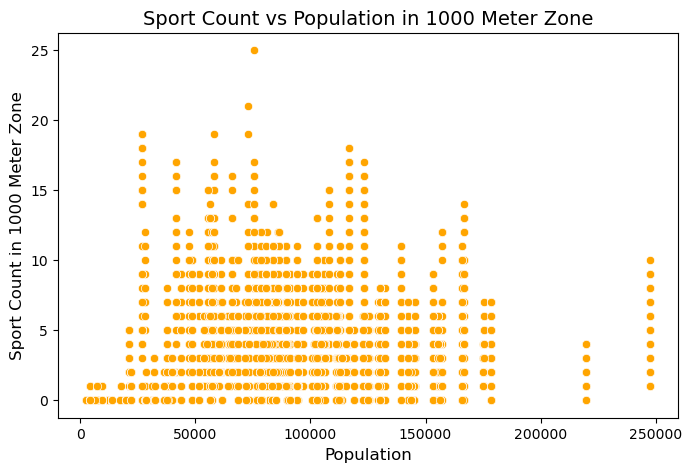

In [120]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=reduced_df['raion_popul'], y=reduced_df['sport_count_1000'], color="orange")
plt.title('Sport Count vs Population in 1000 Meter Zone', fontsize=14)
plt.xlabel('Population', fontsize=12)
plt.ylabel('Sport Count in 1000 Meter Zone', fontsize=12)
plt.show()

As population increases, so does the number of sports facilities.

## Categorical Feature Analysis

In [121]:
for column in reduced_df.select_dtypes(include='object').columns:
    reduced_df[column] = reduced_df[column].astype('category')

In [122]:
reduced_df.select_dtypes(include='category').nunique()

product_type                            2
sub_area                              145
culture_objects_top_25                  2
thermal_power_plant_raion               2
incineration_raion                      2
oil_chemistry_raion                     2
radiation_raion                         2
railroad_terminal_raion                 2
big_market_raion                        2
nuclear_reactor_raion                   2
detention_facility_raion                2
water_1line                             2
big_road1_1line                         2
railroad_1line                          2
ecology                                 5
modern_education_share                  4
num_room_binned                         4
cafe_sum_1000_min_price_avg_binned      3
cafe_sum_1500_min_price_avg_binned      3
cafe_sum_500_min_price_avg_binned       3
cafe_sum_2000_min_price_avg_binned      3
dtype: int64

After reviewing the categorical columns in the reduced dataset, I found an error in the `modern_education_share` column. Upon inspection using:

In [123]:
reduced_df.select_dtypes(include='category').modern_education_share.unique()

[0, '90,92', '93,08', '95,4918']
Categories (4, object): [0, '90,92', '93,08', '95,4918']

I noticed that `modern_education_share` contained values like 0, '90,92', '93,08', and '95,4918'. These entries are problematic because some values use commas (,) as decimal separators, causing parsing issues when attempting to work with this column numerically.

In [124]:
reduced_df['modern_education_share'] = reduced_df['modern_education_share'].astype(str).replace({',': '.'}, regex=True)

To resolve this, I first converted all values to strings and then replaced commas with dots, enabling proper float conversion:

In [125]:
reduced_df['modern_education_share'] = reduced_df['modern_education_share'].astype(float)

This approach ensures consistent formatting by first treating all entries as strings, then converting commas to dots, and finally casting the column to float. Now, `modern_education_share` is correctly formatted as a numeric column, ready for further analysis or modeling.

In [126]:
reduced_df.select_dtypes(include='category').nunique()

product_type                            2
sub_area                              145
culture_objects_top_25                  2
thermal_power_plant_raion               2
incineration_raion                      2
oil_chemistry_raion                     2
radiation_raion                         2
railroad_terminal_raion                 2
big_market_raion                        2
nuclear_reactor_raion                   2
detention_facility_raion                2
water_1line                             2
big_road1_1line                         2
railroad_1line                          2
ecology                                 5
num_room_binned                         4
cafe_sum_1000_min_price_avg_binned      3
cafe_sum_1500_min_price_avg_binned      3
cafe_sum_500_min_price_avg_binned       3
cafe_sum_2000_min_price_avg_binned      3
dtype: int64

I identified that certain features, such as `product_type`, `thermal_power_plant_raion` and `water_1line` have only **2 unique values**, making them binary and suitable for **0/1 (binary) encoding**. The `sub_area` feature has high cardinality with **145 unique values**, indicating it may need advanced encoding techniques. Features like `ecology` **(5 categories)** and `modern_education_share` **(4 categories)** can likely be handled with **one-hot encoding**. I will now apply the appropriate encoding strategies to transform these features for further analysis and modeling.

In [127]:
categorical_columns = reduced_df.select_dtypes(include='category')

### Binary Features Analysis

I will start with Analysis of the binary features.

In [128]:
binary_features = [col for col in categorical_columns if categorical_columns[col].nunique() == 2]

In [129]:
binary_features

['product_type',
 'culture_objects_top_25',
 'thermal_power_plant_raion',
 'incineration_raion',
 'oil_chemistry_raion',
 'radiation_raion',
 'railroad_terminal_raion',
 'big_market_raion',
 'nuclear_reactor_raion',
 'detention_facility_raion',
 'water_1line',
 'big_road1_1line',
 'railroad_1line']

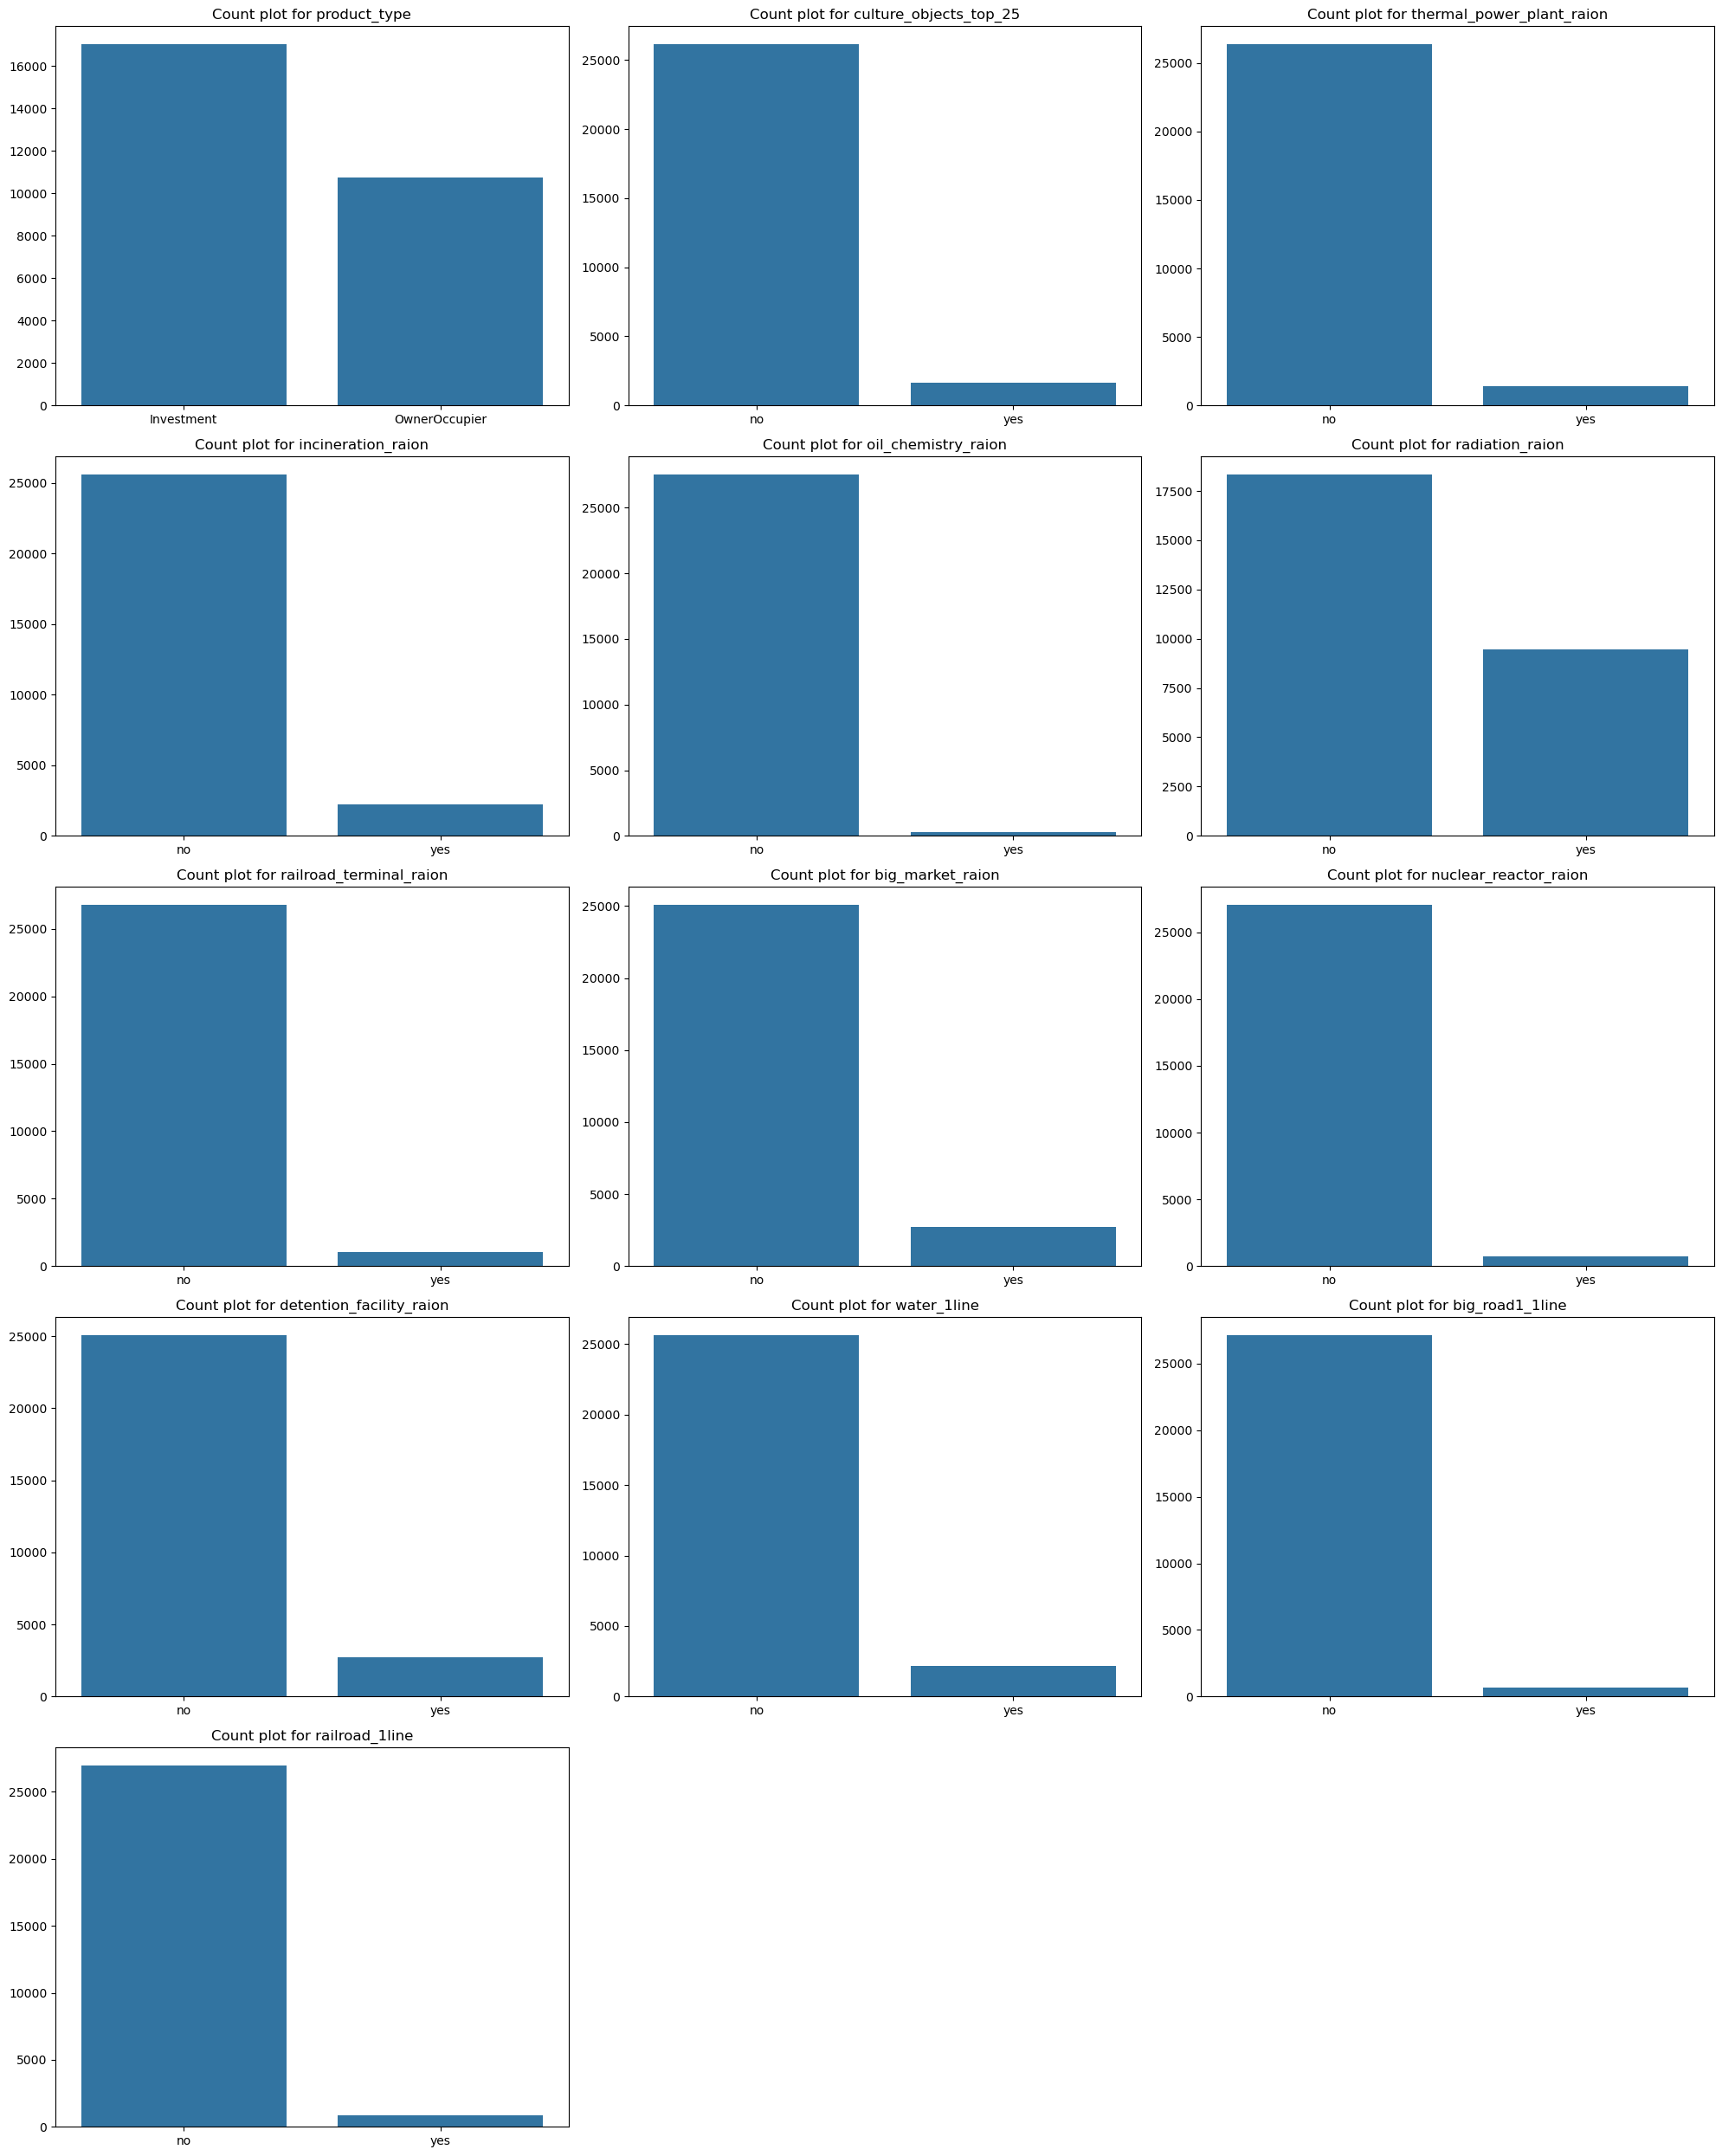

In [130]:
n_cols = 3 
n_rows = len(binary_features) // n_cols + (1 if len(binary_features) % n_cols != 0 else 0) 

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))
axes = axes.flatten()

for i, col in enumerate(binary_features):
    sns.countplot(x=col, data=reduced_df, ax=axes[i])
    axes[i].set_title(f'Count plot for {col}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

### Multiclass Features Analysis

Now, I will handle the multiclass features.

In [131]:
multiclass_features = [col for col in categorical_columns if 2 < categorical_columns[col].nunique() < 10]

In [132]:
multiclass_features

['ecology',
 'num_room_binned',
 'cafe_sum_1000_min_price_avg_binned',
 'cafe_sum_1500_min_price_avg_binned',
 'cafe_sum_500_min_price_avg_binned',
 'cafe_sum_2000_min_price_avg_binned']

In my case the only column in this group is `ecology`.

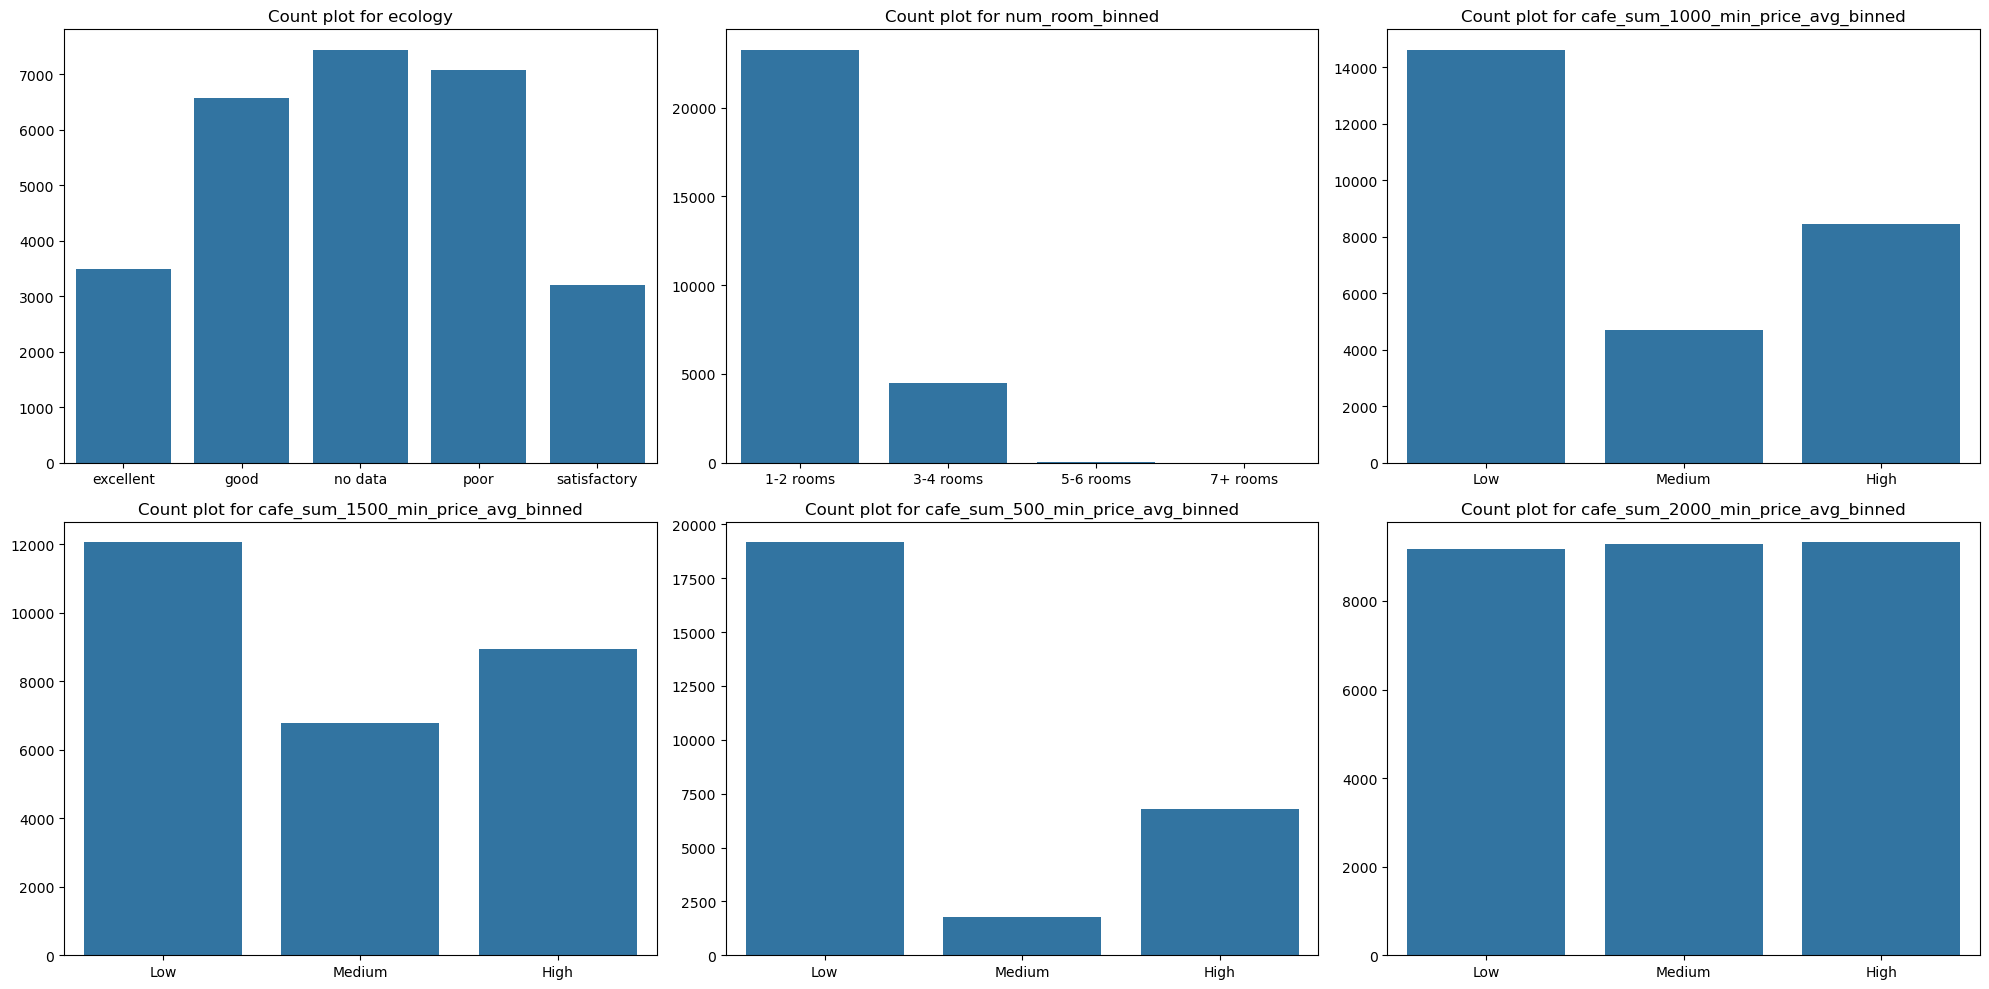

In [133]:
n_cols = 3 
n_rows = len(multiclass_features) // n_cols + (1 if len(multiclass_features) % n_cols != 0 else 0) 

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))
axes = axes.flatten()

for i, col in enumerate(multiclass_features):
    sns.countplot(x=col, data=reduced_df, ax=axes[i])
    axes[i].set_title(f'Count plot for {col}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [134]:
reduced_df.ecology

0                good
1           excellent
2                poor
3                good
4           excellent
             ...     
30465       excellent
30466            good
30468         no data
30469    satisfactory
30470            poor
Name: ecology, Length: 27786, dtype: category
Categories (5, object): ['excellent', 'good', 'no data', 'poor', 'satisfactory']

In [135]:
mapping = {
    'excellent': 5,
    'good': 4,
    'satisfactory': 3,
    'poor': 2,
    'no data': 1
}

reduced_df['ecology'] = reduced_df['ecology'].replace(mapping)

In [136]:
reduced_df['ecology']

0        4
1        5
2        2
3        4
4        5
        ..
30465    5
30466    4
30468    1
30469    3
30470    2
Name: ecology, Length: 27786, dtype: category
Categories (5, int64): [5, 4, 1, 2, 3]

### Analysis of Categorical Features with High Cardinality

In [137]:
high_cardinality_features = [col for col in categorical_columns if 10 < categorical_columns[col].nunique()]

In [138]:
high_cardinality_features

['sub_area']

In [139]:
reduced_df.sub_area

0                    Bibirevo
1           Nagatinskij Zaton
2              Tekstil'shhiki
3                      Mitino
4                   Basmannoe
                 ...         
30465                Tverskoe
30466                Otradnoe
30468    Poselenie Vnukovskoe
30469            Obruchevskoe
30470             Novogireevo
Name: sub_area, Length: 27786, dtype: category
Categories (145, object): ['Ajeroport', 'Akademicheskoe', 'Alekseevskoe', 'Altuf'evskoe', ..., 'Zamoskvorech'e', 'Zapadnoe Degunino', 'Zjablikovo', 'Zjuzino']

In [140]:
sub_area_to_district = {
    "Bibirevo": "Northern Administrative Okrug",
    "Nagatinskij Zaton": "Southern Administrative Okrug",
    "Tekstil'shhiki": "Southeast Administrative Okrug",
    "Mitino": "Western Administrative Okrug",
    "Basmannoe": "Central Administrative Okrug",
    "Nizhegorodskoe": "Eastern Administrative Okrug",
    "Sokol'niki": "Eastern Administrative Okrug",
    "Koptevo": "Northern Administrative Okrug",
    "Kuncevo": "Western Administrative Okrug",
    "Kosino-Uhtomskoe": "Southeast Administrative Okrug",
    "Zapadnoe Degunino": "Northern Administrative Okrug",
    "Presnenskoe": "Central Administrative Okrug",
    "Lefortovo": "Southeast Administrative Okrug",
    "Mar'ino": "Southern Administrative Okrug",
    "Kuz'minki": "Southeast Administrative Okrug",
    "Nagornoe": "Southern Administrative Okrug",
    "Gol'janovo": "Eastern Administrative Okrug",
    "Vnukovo": "Western Administrative Okrug",
    "Juzhnoe Tushino": "Western Administrative Okrug",
    "Severnoe Tushino": "Northern Administrative Okrug",
    "Chertanovo Central'noe": "Southern Administrative Okrug",
    "Fili Davydkovo": "Western Administrative Okrug",
    "Otradnoe": "Northwestern Administrative Okrug",
    "Novo-Peredelkino": "Western Administrative Okrug",
    "Bogorodskoe": "Eastern Administrative Okrug",
    "Jaroslavskoe": "Northern Administrative Okrug",
    "Strogino": "Western Administrative Okrug",
    "Hovrino": "Northern Administrative Okrug",
    "Moskvorech'e-Saburovo": "Southern Administrative Okrug",
    "Staroe Krjukovo": "Northwestern Administrative Okrug",
    "Ljublino": "Southern Administrative Okrug",
    "Caricyno": "Southern Administrative Okrug",
    "Veshnjaki": "Eastern Administrative Okrug",
    "Danilovskoe": "Southern Administrative Okrug",
    "Preobrazhenskoe": "Eastern Administrative Okrug",
    "Kon'kovo": "Southern Administrative Okrug",
    "Brateevo": "Southern Administrative Okrug",
    "Vostochnoe Izmajlovo": "Eastern Administrative Okrug",
    "Vyhino-Zhulebino": "Southeast Administrative Okrug",
    "Donskoe": "Southern Administrative Okrug",
    "Novogireevo": "Eastern Administrative Okrug",
    "Juzhnoe Butovo": "Southern Administrative Okrug",
    "Sokol": "Northern Administrative Okrug",
    "Kurkino": "Northwestern Administrative Okrug",
    "Izmajlovo": "Eastern Administrative Okrug",
    "Severnoe Medvedkovo": "Northern Administrative Okrug",
    "Rostokino": "Eastern Administrative Okrug",
    "Orehovo-Borisovo Severnoe": "Southern Administrative Okrug",
    "Ochakovo-Matveevskoe": "Southwestern Administrative Okrug",
    "Taganskoe": "Central Administrative Okrug",
    "Dmitrovskoe": "Northern Administrative Okrug",
    "Orehovo-Borisovo Juzhnoe": "Southern Administrative Okrug",
    "Teplyj Stan": "Southern Administrative Okrug",
    "Babushkinskoe": "Northern Administrative Okrug",
    "Pokrovskoe Streshnevo": "Northern Administrative Okrug",
    "Obruchevskoe": "Southwestern Administrative Okrug",
    "Filevskij Park": "Western Administrative Okrug",
    "Troparevo-Nikulino": "Southwestern Administrative Okrug",
    "Severnoe Butovo": "Southern Administrative Okrug",
    "Hamovniki": "Central Administrative Okrug",
    "Solncevo": "Southwestern Administrative Okrug",
    "Dorogomilovo": "Central Administrative Okrug",
    "Timirjazevskoe": "Northern Administrative Okrug",
    "Lianozovo": "Northern Administrative Okrug",
    "Pechatniki": "Southeastern Administrative Okrug",
    "Krjukovo": "Zelenograd Administrative Okrug",
    "Jasenevo": "Southern Administrative Okrug",
    "Chertanovo Severnoe": "Southern Administrative Okrug",
    "Rjazanskij": "Southeastern Administrative Okrug",
    "Silino": "Eastern Administrative Okrug",
    "Ivanovskoe": "Southeastern Administrative Okrug",
    "Golovinskoe": "Northern Administrative Okrug",
    "Novokosino": "Eastern Administrative Okrug",
    "Nagatino-Sadovniki": "Southern Administrative Okrug",
    "Birjulevo Vostochnoe": "Southern Administrative Okrug",
    "Severnoe Izmajlovo": "Eastern Administrative Okrug",
    "Sokolinaja Gora": "Eastern Administrative Okrug",
    "Vostochnoe Degunino": "Northern Administrative Okrug",
    "Prospekt Vernadskogo": "Western Administrative Okrug",
    "Savelki": "Northwestern Administrative Okrug",
    "Ajeroport": "Northern Administrative Okrug",
    "Vojkovskoe": "Northern Administrative Okrug",
    "Beskudnikovskoe": "Northern Administrative Okrug",
    "Krylatskoe": "Western Administrative Okrug",
    "Juzhnoportovoe": "Southern Administrative Okrug",
    "Perovo": "Southeastern Administrative Okrug",
    "Akademicheskoe": "Southern Administrative Okrug",
    "Horoshevo-Mnevniki": "Northern Administrative Okrug",
    "Shhukino": "Northwestern Administrative Okrug",
    "Kapotnja": "Southern Administrative Okrug",
    "Horoshevskoe": "Northern Administrative Okrug",
    "Marfino": "Northern Administrative Okrug",
    "Chertanovo Juzhnoe": "Southern Administrative Okrug",
    "Savelovskoe": "Northern Administrative Okrug",
    "Birjulevo Zapadnoe": "Southern Administrative Okrug",
    "Nekrasovka": "Southeastern Administrative Okrug",
    "Cheremushki": "Southern Administrative Okrug",
    "Sviblovo": "Eastern Administrative Okrug",
    "Alekseevskoe": "Northern Administrative Okrug",
    "Krasnosel'skoe": "Central Administrative Okrug",
    "Kotlovka": "Southern Administrative Okrug",
    "Zjuzino": "Southern Administrative Okrug",
    "Ostankinskoe": "Northern Administrative Okrug",
    "Tverskoe": "Central Administrative Okrug",
    "Losinoostrovskoe": "Eastern Administrative Okrug",
    "Butyrskoe": "Northern Administrative Okrug",
    "Matushkino": "Zelenograd Administrative Okrug",
    "Metrogorodok": "Eastern Administrative Okrug",
    "Juzhnoe Medvedkovo": "Northern Administrative Okrug",
    "Lomonosovskoe": "Southern Administrative Okrug",
    "Jakimanka": "Central Administrative Okrug",
    "Mozhajskoe": "Western Administrative Okrug",
    "Levoberezhnoe": "Northern Administrative Okrug",
    "Mar'ina Roshha": "Central Administrative Okrug",
    "Gagarinskoe": "Southern Administrative Okrug",
    "Zamoskvorech'e": "Central Administrative Okrug",
    "Altuf'evskoe": "Northern Administrative Okrug",
    "Ramenki": "Western Administrative Okrug",
    "Zjablikovo": "Southern Administrative Okrug",
    "Meshhanskoe": "Northern Administrative Okrug",
    "Severnoe": "Northern Administrative Okrug",
    "Begovoe": "Northern Administrative Okrug",
    "Arbat": "Central Administrative Okrug",
    "Poselenie Sosenskoe": "Troitsky Administrative Okrug",
    "Poselenie Moskovskij": "Troitsky Administrative Okrug",
    "Poselenie Pervomajskoe": "Troitsky Administrative Okrug",
    "Poselenie Desjonovskoe": "Troitsky Administrative Okrug",
    "Poselenie Voskresenskoe": "Troitsky Administrative Okrug",
    "Poselenie Mosrentgen": "Troitsky Administrative Okrug",
    "Troickij okrug": "Troitsky Administrative Okrug",
    "Poselenie Shherbinka": "Southern Administrative Okrug",
    "Poselenie Filimonkovskoe": "Western Administrative Okrug",
    "Poselenie Vnukovskoe": "Western Administrative Okrug",
    "Poselenie Marushkinskoe": "Southwestern Administrative Okrug",
    "Poselenie Shhapovskoe": "Western Administrative Okrug",
    "Poselenie Rjazanovskoe": "Southeastern Administrative Okrug",
    "Poselenie Kokoshkino": "Western Administrative Okrug",
    "Vostochnoe": "Eastern Administrative Okrug",
    "Poselenie Krasnopahorskoe": "Northwestern Administrative Okrug",
    "Poselenie Novofedorovskoe": "Eastern Administrative Okrug",
    "Poselenie Voronovskoe": "Northwestern Administrative Okrug",
    "Poselenie Klenovskoe": "Troitsky Administrative Okrug",
    "Poselenie Rogovskoe": "Southwestern Administrative Okrug",
    "Poselenie Kievskij": "Troitsky Administrative Okrug",
    "Molzhaninovskoe": "Northern Administrative Okrug",
    "Poselenie Mihajlovo-Jarcevskoe": "Northwestern Administrative Okrug",
}

In [141]:
len(sub_area_to_district)

146

In [142]:
sub_area_df = pd.DataFrame(list(sub_area_to_district.items()), columns=["sub_area", "district"])

In [143]:
sub_area_df

sub_area                           district
0                          Bibirevo      Northern Administrative Okrug
1                 Nagatinskij Zaton      Southern Administrative Okrug
2                    Tekstil'shhiki     Southeast Administrative Okrug
3                            Mitino       Western Administrative Okrug
4                         Basmannoe       Central Administrative Okrug
..                              ...                                ...
141            Poselenie Klenovskoe      Troitsky Administrative Okrug
142             Poselenie Rogovskoe  Southwestern Administrative Okrug
143              Poselenie Kievskij      Troitsky Administrative Okrug
144                 Molzhaninovskoe      Northern Administrative Okrug
145  Poselenie Mihajlovo-Jarcevskoe  Northwestern Administrative Okrug

[146 rows x 2 columns]

In [144]:
sub_area_df.to_csv("sub_area_to_district.csv", index=False)

In [145]:
reduced_df["district"] = reduced_df["sub_area"].map(sub_area_to_district)

In [146]:
reduced_df["district"]

0            Northern Administrative Okrug
1            Southern Administrative Okrug
2           Southeast Administrative Okrug
3             Western Administrative Okrug
4             Central Administrative Okrug
                       ...                
30465         Central Administrative Okrug
30466    Northwestern Administrative Okrug
30468         Western Administrative Okrug
30469    Southwestern Administrative Okrug
30470         Eastern Administrative Okrug
Name: district, Length: 27786, dtype: object

# 7. Feature engineering

Droping the columns that i have transformed in some way earlier in the project.

In [147]:
columns_to_drop = [
    'price_doc',
    'full_sq',
    'cafe_sum_1000_min_price_avg', 
    'cafe_sum_1500_min_price_avg', 
    'cafe_sum_500_min_price_avg', 
    'cafe_sum_2000_min_price_avg',
    'num_room',
    'sub_area',
    'id'
]

reduced_df = reduced_df.drop(columns=columns_to_drop)

My plans are to split the dataset by year to ensure that our model is trained on historical data and tested on more recent data, mimicking a real-world scenario. To achieve this, we need to extract day, month, and year from the timestamp column. These features will help our model capture temporal patterns and seasonal effects, potentially improving its predictive accuracy.

In [148]:
reduced_df['day'] = reduced_df['timestamp'].dt.day
reduced_df['month'] = reduced_df['timestamp'].dt.month
reduced_df['year'] = reduced_df['timestamp'].dt.year

Having the needed columns, I can now drop the original `timestamp` column.

In [149]:
reduced_df = reduced_df.drop(columns=['timestamp'])

In [150]:
reduced_df['year'].value_counts().sort_index()

year
2011      608
2012     4311
2013     7370
2014    12510
2015     2987
Name: count, dtype: int64

In [151]:
reduced_df.shape

(27786, 134)

In [152]:
final_dataset = pd.get_dummies(reduced_df)

In [153]:
final_dataset.shape

(27786, 172)

## 8. Train test split

In [154]:
features = final_dataset.drop(columns=['log_price_doc'])  
target_variable = final_dataset['log_price_doc']  

In [155]:
tscv = TimeSeriesSplit(n_splits=4)

for fold, (train_index, test_index) in enumerate(tscv.split(features), 1):
    print(f"Fold {fold}:")
    print(f"Train size: {len(train_index)}, Test size: {len(test_index)}")
    print(f"Training data range: {train_index[0]} to {train_index[-1]}")
    print(f"Test data range: {test_index[0]} to {test_index[-1]}")
    print("-" * 40)

Fold 1:
Train size: 5558, Test size: 5557
Training data range: 0 to 5557
Test data range: 5558 to 11114
----------------------------------------
Fold 2:
Train size: 11115, Test size: 5557
Training data range: 0 to 11114
Test data range: 11115 to 16671
----------------------------------------
Fold 3:
Train size: 16672, Test size: 5557
Training data range: 0 to 16671
Test data range: 16672 to 22228
----------------------------------------
Fold 4:
Train size: 22229, Test size: 5557
Training data range: 0 to 22228
Test data range: 22229 to 27785
----------------------------------------


In [156]:
final_dataset.iloc[11114].year

2013

# 9. Model selection

Since this is a regression problem the candidate models are:
1. Linear Models:
- Ridge Regression
- Lasso Regression
- ElasticNet
2. Tree-Based Models:
- Decision Tree Regressor
- Random Forest Regressor
Gradient Boosting Regressor (e.g., XGBoost, LightGBM, CatBoost)
3. Others:
- k-Nearest Neighbors Regressor (KNN)
- Support Vector Regressor (SVR)

10. Model evaluation - MSE, RMSE

11. Hyperparameter tuning

12. Here you can see the p-values of the features in the linear regression, the shap values in the other models, feature importances as well. The features that have high p-values, and low feature importances can be removed - but you have to see how it impacts the performance of the model.

(optional) unsupervised learning

13. Conclusion